In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import warnings
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,precision_score,recall_score,f1_score,accuracy_score
sys.path.append('../')
pd.options.mode.chained_assignment = None 



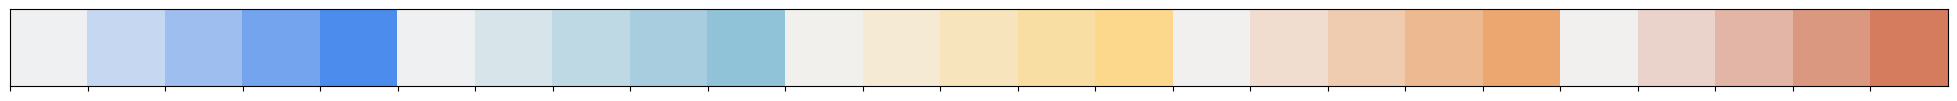

In [2]:
colors =['#4C8CED','#90C2D8','#FCD88D','#ECA771','#D47C5D']
full_palette = sns.color_palette(colors)
sns.set_palette(full_palette)
cmap = LinearSegmentedColormap.from_list("custom_cmap", full_palette)
third_class = 'unknown'
expanded_palette = []

for color in colors:
    shades = sns.light_palette(color, n_colors=5)
    expanded_palette.extend(shades)

expanded_palette
sns.palplot(expanded_palette)

In [3]:
order = ['entering','exiting','entering-exiting','exiting-entering','unknown']

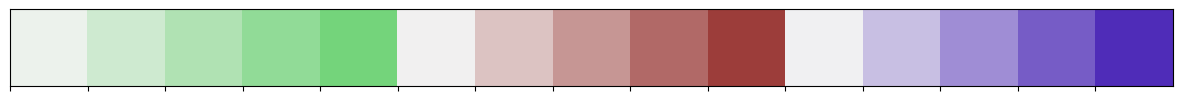

In [4]:
colors =['#74d47b','#9c3d3a','#4f2cb8']
full_palette = sns.color_palette(colors)
expanded_palette2 = []
for color in colors:
    shades = sns.light_palette(color, n_colors=5)
    expanded_palette2.extend(shades)

sns.palplot(expanded_palette2)

In [5]:
palette = {
    "THRS_BIDIRECTIONAL":    expanded_palette2[4],
    "THRS_DOUBLE": expanded_palette2[3],
    "THRS_SINGLE":expanded_palette2[2],
    "BEE_ANGLE_BIDIRECTIONAL": expanded_palette2[9],
    "BEE_ANGLE_SUM":expanded_palette2[8],
    "BEE_ANGLE_START":expanded_palette2[7],
    "BEE_ANGLE_END":expanded_palette2[6],
    "DISP_BIDIRECTIONAL":expanded_palette2[14],
    "DISP_START_END":expanded_palette2[13],
    "DISP_START":expanded_palette2[12],
    "DISP_END":expanded_palette2[11]
}

In [6]:
algo_order = ["THRS_SINGLE","THRS_DOUBLE","BEE_ANGLE_SUM","BEE_ANGLE_START","BEE_ANGLE_END",
"DISP_START_END","DISP_START","DISP_END","THRS_BIDIRECTIONAL","DISP_BIDIRECTIONAL","BEE_ANGLE_BIDIRECTIONAL"]

In [7]:
distpalette = {
    "entering": expanded_palette[4],
    "exiting": expanded_palette[9],
    "entering-exiting": expanded_palette[14],
    "exiting-entering": expanded_palette[19],
    "unknown": expanded_palette[24]
}

In [8]:
vdf = pd.read_csv("beeActivity.csv")
#vdf = vdf.drop_duplicates(subset=['track_starttime','track_tagid'], keep='last')

In [9]:
#DISTANCE THRESHOLD
#used to classify an event as entering or exiting
#when two consecutive detections of the same event 
#have this distance in y position, they are utilized to predict
#the trajectory. If not then it checks the detection prior for
#the distance threshold, and continues doing so until it finds
#the last detection in the event or until it finds a distance
#of more than the threshold

t2 = 100

#ANGLE THRESHOLD
#used to generate angle ranges for classifying as exiting
#or entering

angle = 10


## APPROACHES

In [10]:
#APPROACHES 1 - INSIDE-OUTSIDE OR OUTSIDE-INSIDE

#two thresholds
def in_out(data):
    exiting = ['inside_outside','ramp_outside']
    entering = ['outside_inside','outside_ramp']
    first = data['track_shape'].iloc[0].split("_")[0]
    last =  data['track_shape'].iloc[-1].split("_")[1]
    shape = f'{first}_{last}'
    if shape in exiting:
        return "exiting"
    elif shape in entering:
        return "entering"
    else:
        return "unknown"

#single threshold
def in_out_single(data):
    if data['track_starty'].iloc[0] < 770:
        str1 = 'outside'
    else:
        str1 = 'inside'

    if data['track_endy'].iloc[-1] < 770:
        str2 = "outside"
    else:
        str2 = "inside"
    track_shape = f'{str1}_{str2}'
    exiting = ['inside_outside']
    entering = ['outside_inside']
    if track_shape in exiting:
        return "exiting"
    elif track_shape in entering:
        return "entering"
    else:
        return "unknown"

#APPROACHES 2 ITERATE BACKWARDS DISPLACEMENT
def displacement(data):  

        #convert to numpy for speed
        y = data["cy"].to_numpy()
        #assign final and obtain all differences
        final = y[-1]
        diff = y - final

        #obtain all values where it surpasses the threshold
        idx = np.where(np.abs(diff) >= t2)[0]
        #extract only the last one
        cur = diff[idx[-1]] if idx.size else diff[0]

        if cur > 0:
            return "exiting"
        elif cur < 0:
            return "entering"
        else:
            return "unknown"

        
            

#APPROACHES 3 SUMMED DIRECTIONAL ANGLE

def angles(data):
    exit_min = 180 + angle
    exit_max = 360 - angle
    enter_min = angle
    enter_max = 180 - angle

    #obtain all angles of event
    coordinates = data['angle'].to_numpy()

    #obtain vector angle
    unit_dx = np.cos(np.deg2rad(coordinates))
    unit_dy = np.sin(np.deg2rad(coordinates))
    avg_x = np.average(unit_dx)
    avg_y = np.average(unit_dy)
    if avg_x == 0 and avg_y == 0:
        deg = 0
    elif avg_x == 0 and avg_y != 0:
        if avg_y > 0:
            deg = 270
        elif avg_y < 0:
            deg = 90
    else:
        # determine direction angle using arctan
        deg = np.rad2deg(np.arctan(avg_y/avg_x))
                    
        # since arctan limits are (-90,90), use coordinate directions to 
        # correct the angle to be within standard [0,360) range
        if avg_x > 0 and avg_y >= 0:
            deg = deg
        elif avg_x < 0 and avg_y >= 0:
            deg = 180 + deg
        elif avg_x < 0 and avg_y < 0:
            deg = deg + 180
        elif avg_x > 0 and avg_y < 0:
            deg = 360 + deg

    if deg >= exit_min and deg <= exit_max:
        return 'exiting'
    elif deg >= enter_min and deg <= enter_max:
        return 'entering'
    else:
        return 'unknown'

#subfunction of previous application, except with one
#single angle instead

def getangle(coordinates):
    exit_min = 180 + angle
    exit_max = 360 - angle
    enter_min = angle
    enter_max = 180 - angle

    #normalize angle from -180 to 180 to 0 to 360
    deg = coordinates % 360

    if deg >= exit_min and deg <= exit_max:
        return 'exiting'
    elif deg >= enter_min and deg <= enter_max:
        return 'entering'
    else:
        return 'unknown'

#APPROACHES 4 LAST DIRECTIONAL ANGLE

def lastangle(data):
   
    coordinates = data['angle'].iloc[-1]

    return getangle(coordinates)


#APPROACHES 5 INIT - FINAL DISPLACEMENT
def displacementinit(data):            
        coordinates = data['cy']
        
        final = coordinates.iloc[-1]
        init = coordinates.iloc[0]

        if init > final:
            return 'exiting'
        elif final > init:
            return 'entering'
        else:
            return 'unknown'             

#APPROACHES 6 FIRST DIRECTIONAL ANGLE

def firstangle(data):
   
    coordinates = data['angle'].iloc[0]

    return getangle(coordinates)


#APPROACHES 7 ITERATE FORWARDS DISPLACEMENT
def displacement2(data):            
        #convert to numpy for speed
        y = data["cy"].to_numpy()
        #assign first and obtain all differences
        first = y[0]
        diff = y - first

        #obtain all values where it surpasses the threshold
        idx = np.where(np.abs(diff) >= t2)[0]
        #extract only the first one
        cur = diff[idx[0]] if idx.size else diff[0]

        if cur < 0:
            return 'exiting'
        elif cur > 0:
            return 'entering'
        else:
            return 'unknown'
            


####CLASSIFICATION AS ENTERING-EXITING OR EXITING-ENTERING

#APPROACHES 1 ITERATE BACKWARDS AND FORWARDS DISPLACEMENT
#COMBINES FORWARD ITERATION AND BACKWARDS ITERATION
def displacementbackforth(data):   


        string2 = displacement(data)
        string = displacement2(data)

        #if both directions are the same, return value
        #else return compound event
        return string if string == string2 else f"{string}-{string2}"
        

#APPROACHES 2 FIRST AND LAST DIRECTIONAL ANGLE
#COMBINES FIRST ANGLE AND LAST ANGLE

def lastfirstangle(data):

    coordinates = data['angle'].iloc[-1]

    string2 = getangle(coordinates)

    coordinates = data['angle'].iloc[0]

    string = getangle(coordinates)

    #if both directions are the same, return value
    #else return compound event
    return string if string == string2 else f"{string}-{string2}"


#APPROACHES 3 THRESHOLD BIDIRECTIONAL
def in_out2(data):
    first = data['track_shape'].iloc[0].split("_")[0]
    last =  data['track_shape'].iloc[-1].split("_")[1]
    shape = f'{first}_{last}'
    if shape == "inside_outside" or shape == "ramp_outside":
        return "exiting"
    elif shape == "outside_inside" or shape == "outside_ramp":
        return "entering"
    elif shape == "outside_outside":
        return "entering-exiting"
    elif shape == "inside_inside":
        return "exiting-entering"
    else:
        return "unknown"
        

In [11]:
#read cheatsheet of all cases

cheatsheet = pd.read_csv("cheatsheet.csv")

#scores that will be used in the analysis

scores = ["precision","recall","f1-score","accuracy"]

In [12]:
#function that obtains all scores from classification report for each algorithm

def calculate_scores(matrix,cheatsheet,labels):
    scores = {}
    for column in matrix.columns:
        col = matrix[column]
        report = classification_report(
        cheatsheet,
        col,
        target_names=labels,
        labels=labels,
        output_dict = True
        )
        report['accuracy']= accuracy_score(cheatsheet, col)
        scores[column] = report
    return scores

In [13]:
#unpacks dict to turn into melted df

def flatten_dict(scores,labels):
    new_dict = {'algo':[],'score':[],'class':[],'value':[]}
    for algo in scores.keys():
        #c = class
        for c in scores[algo].keys():
            if c == "accuracy":
                new_dict['algo'].append(algo)
                new_dict['score'].append('accuracy')
                new_dict['class'].append(pd.NA)
                new_dict['value'].append(scores[algo]['accuracy'])
            elif c in labels:
                for score in scores[algo][c].keys():
                    new_dict['algo'].append(algo)
                    new_dict['score'].append(score)
                    new_dict['value'].append(scores[algo][c][score])
                    new_dict['class'].append(c)
    df = pd.DataFrame.from_dict(new_dict)
    return df

In [14]:
#generates graphs of all scores
#label is used for the name of the file i.e. 'simple', 'compound'
def generate_graphs(the_dict,label):
    for s in scores:
        df = the_dict[the_dict['score'] == s]
        if s == "accuracy":
            fig, ax = plt.subplots(figsize=(8, 5))
            sns.barplot(df,x="algo",y="value",hue="algo",palette=palette,ax=ax,alpha=1.0,saturation=1.0)           
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            ax.set_yticks(np.linspace(0,1,11))
            ax.grid(True, axis="y", color="gray", alpha=0.5) 
            ax.set_axisbelow(True)
            ax.set_xlabel("Algorithm")
            ax.set_ylabel("Accuracy")
            fig.savefig(f"{label}-{s}.png",bbox_inches='tight')
        else:
            plot = sns.FacetGrid(df, col="class", hue="algo",height=5,col_wrap=2, aspect=1.5,palette=palette)
            plot.map(plt.bar,'algo','value',edgecolor='white',linewidth=0.1)
            if len(plot.axes.flat) == 3:
                show_xticks = {1, 2}
            elif len(plot.axes.flat) == 4:
                show_xticks = {2, 3}
            else:
                show_xticks = {0, 1}
            for i, ax in enumerate(plot.axes.flat):
                if i in show_xticks:
                    ax.tick_params(axis='x', labelbottom=True)
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
                else:
                    ax.tick_params(axis='x', labelbottom=False)
            
                ax.set_yticks(np.linspace(0,1,11))
                ax.grid(True, axis="y", color="gray", alpha=0.5)
                ax.set_axisbelow(True)
    
            plot.set_axis_labels(x_var="Algorithm", y_var=s.title())
            plot.fig.subplots_adjust(bottom=0.25)
            plot.savefig(f"{label}-{s}.png",bbox_inches='tight') 

In [15]:
#generates graphs of all scores
#label is used for the name of the file i.e. 'simple', 'compound'
def generate_sidegraphs(the_dict,label):
    for s in scores:
        df = the_dict[the_dict['score'] == s]
        if s == "accuracy":
            continue
        else:
            plot = sns.catplot(data=df, kind="bar", x="algo", y="value", hue="class", palette=distpalette)
            plot.tick_params(axis='x', labelrotation=90)
            ax = plot.ax
            ax.set_yticks(np.linspace(0,1,11))
            ax.grid(True, axis="y", color="gray", alpha=0.5)
            ax.set_axisbelow(True)
    
            plot.set_axis_labels(x_var="Algorithm", y_var=s.title())
            plot.fig.subplots_adjust(bottom=0.25)
            plot.savefig(f"{label}-{s}-side.png",bbox_inches='tight') 

In [16]:
#generates graphs of distribution of classes
#label is used for the name of the file i.e. 'simple', 'compound'
def generate_dist(the_matrix,label):
    the_df = []
    for c in the_matrix.columns:
        column = the_matrix[c]
        values = column.value_counts()
        df = values.rename("count").reset_index()
        df["algo"] = c
        df = df.rename(columns={df.columns[0]:'event'})
        the_df.append(df)
    full_df = pd.concat(the_df, ignore_index=True)

    stacked = full_df.pivot_table(
    index="algo", 
    columns="event", 
    values="count",
    fill_value=0
    )
    stacked = stacked.reindex(the_matrix.columns)
    num_cols = stacked.shape[1]
    if(num_cols > 3):
        stacked = stacked.reindex(columns=order)

    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = np.zeros(len(stacked))

    for event in stacked.columns:
        values = stacked[event].values

        bars = ax.bar(
            stacked.index,
            values,
            bottom=bottom,
            edgecolor="white",
            label=event,
            color=distpalette.get(event)
        )

        bottom += values

    ax.legend(
    title="Class",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
    )

    ax.tick_params(axis='x', labelrotation=90)
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    ax.set_ylabel("Count")
    ax.set_axisbelow(True)
    ax.set_xlabel("Algorithm")
    plt.tight_layout()
    plt.show()

    fig.savefig(f"{label}-count.png",bbox_inches='tight',bbox_extra_artists=(ax.get_legend(),)) 

Testing on simple cases

In [17]:
#compare classifications against ground truth

removed = ['entering-exiting','exiting-entering','unknown']
labels = ['entering','exiting']

cheatsheet1 = cheatsheet[~cheatsheet.event.isin(removed)].reset_index()

functions = {
    'THRS_DOUBLE': in_out,
    'THRS_SINGLE': in_out_single,
    'DISP_START_END': displacementinit,
    'BEE_ANGLE_SUM': angles,
    'DISP_START': displacement2,
    'DISP_END': displacement,
    'BEE_ANGLE_START': firstangle,
    'BEE_ANGLE_END': lastangle,
    
}
functions = {k: functions[k] for k in algo_order if k in functions}

for_matrix = {}

for APPROACHES, func in functions.items():
    for_matrix[APPROACHES] = []

for index, row in cheatsheet1.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['group_id'] == line]

    for APPROACHES, func in functions.items():
        result = func(detections)
        for_matrix[APPROACHES].append(result)
            
        

In [18]:
simple_matrix = pd.DataFrame.from_dict(for_matrix)
score = calculate_scores(simple_matrix,cheatsheet1['event'],labels)
simple_dict = flatten_dict(score,labels)

In [19]:
for col in simple_matrix:
    column = simple_matrix[col]
    print(col)
    print(classification_report(cheatsheet1['event'],column,labels=labels,target_names=labels))

THRS_SINGLE
              precision    recall  f1-score   support

    entering       1.00      0.99      0.99       100
     exiting       1.00      1.00      1.00       159

   micro avg       1.00      1.00      1.00       259
   macro avg       1.00      0.99      1.00       259
weighted avg       1.00      1.00      1.00       259

THRS_DOUBLE
              precision    recall  f1-score   support

    entering       1.00      1.00      1.00       100
     exiting       1.00      0.99      1.00       159

   micro avg       1.00      1.00      1.00       259
   macro avg       1.00      1.00      1.00       259
weighted avg       1.00      1.00      1.00       259

BEE_ANGLE_SUM
              precision    recall  f1-score   support

    entering       0.99      0.90      0.94       100
     exiting       0.97      0.99      0.98       159

   micro avg       0.98      0.96      0.97       259
   macro avg       0.98      0.95      0.96       259
weighted avg       0.98      0.96   

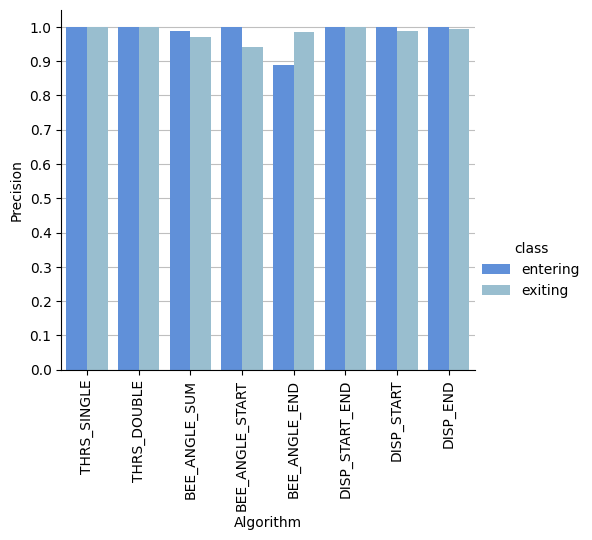

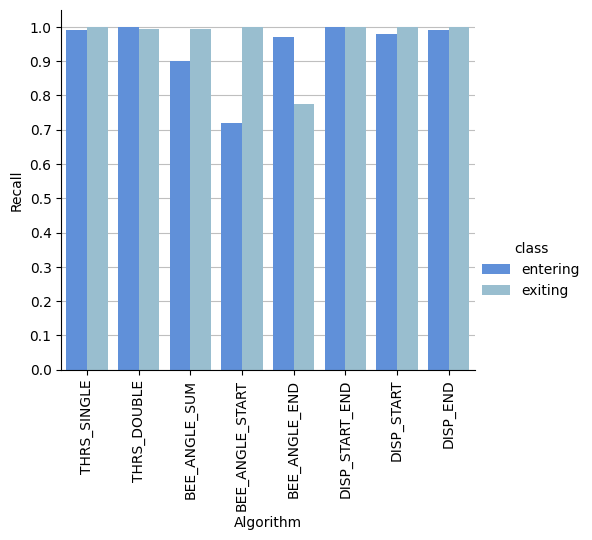

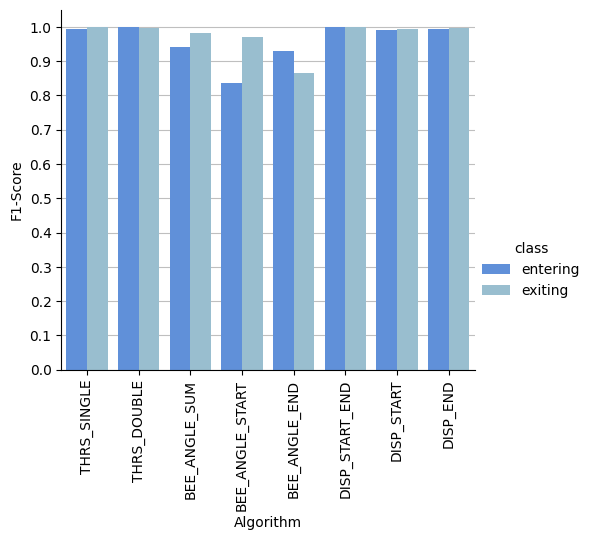

In [20]:
generate_sidegraphs(simple_dict,"simple")

C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

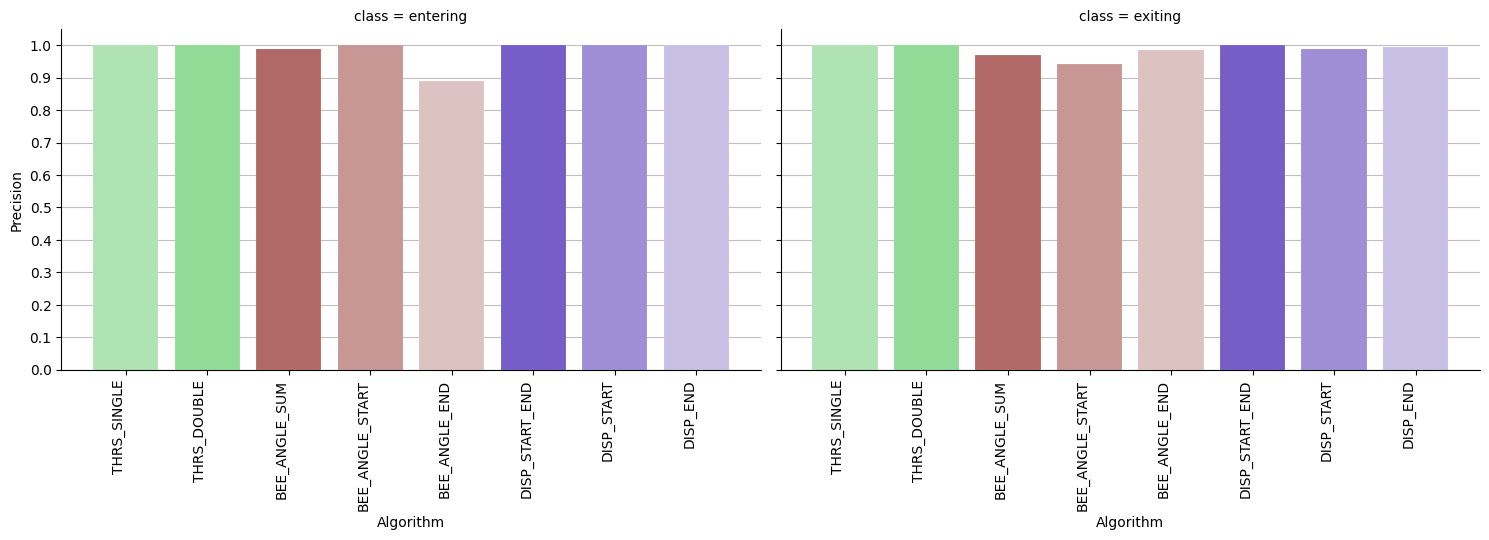

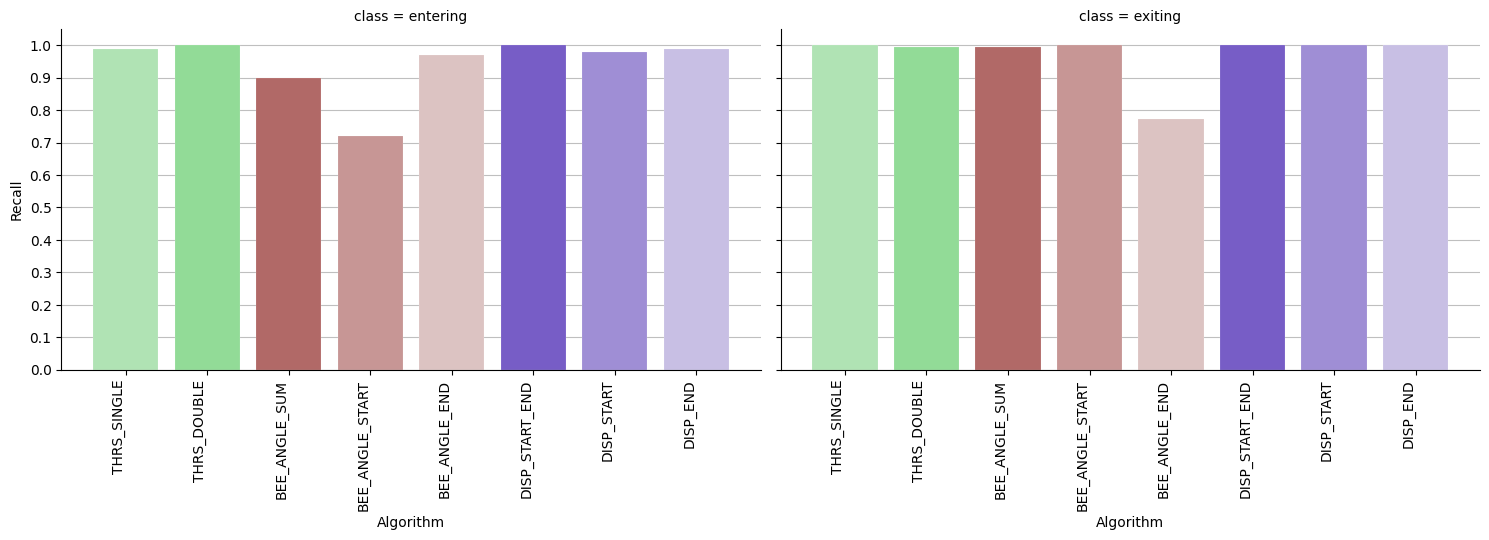

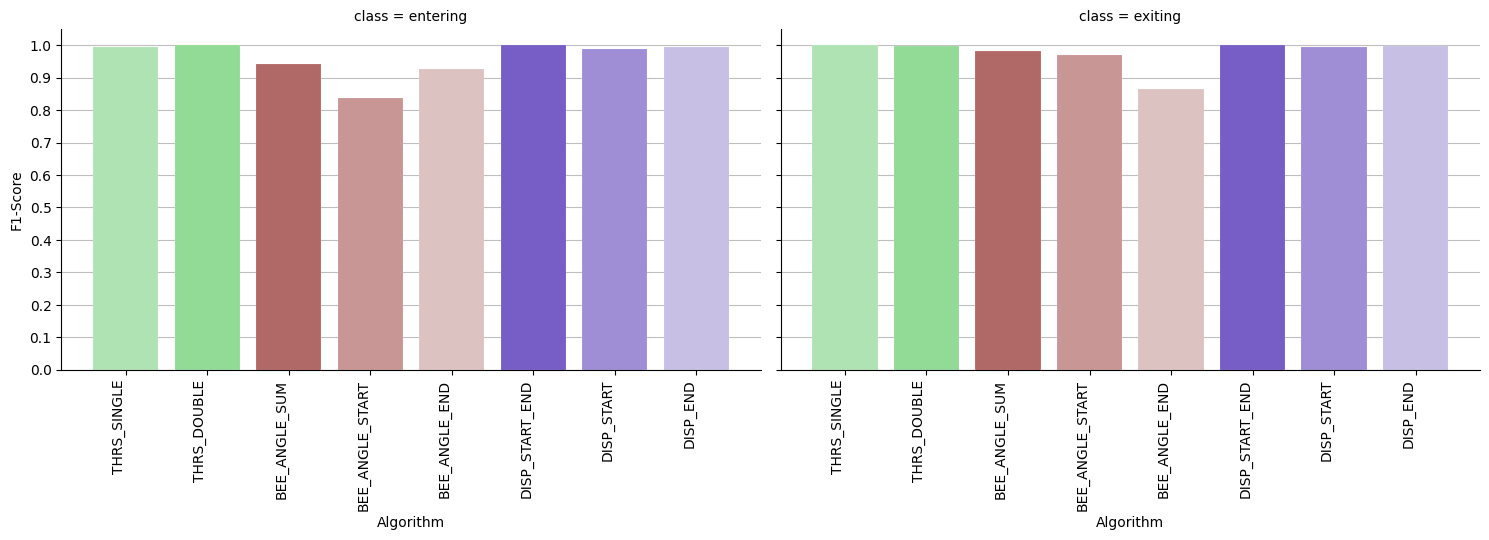

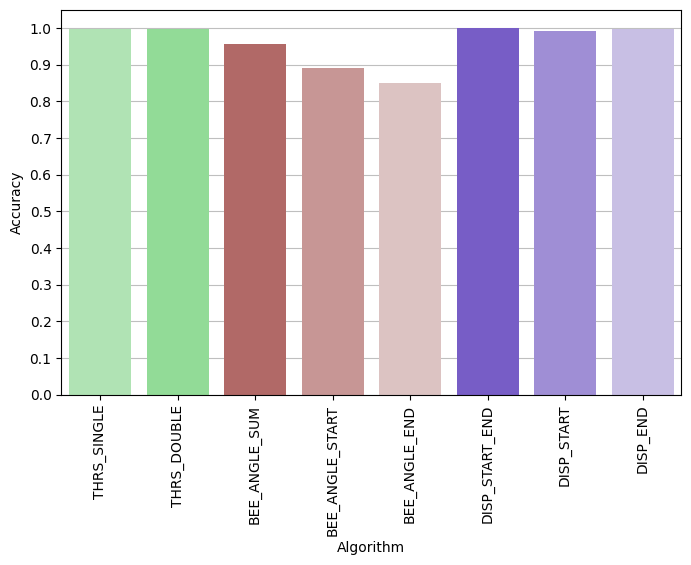

In [21]:
generate_graphs(simple_dict,"simple")

In [22]:
simple_matrix['Actual Values'] = cheatsheet1['event']

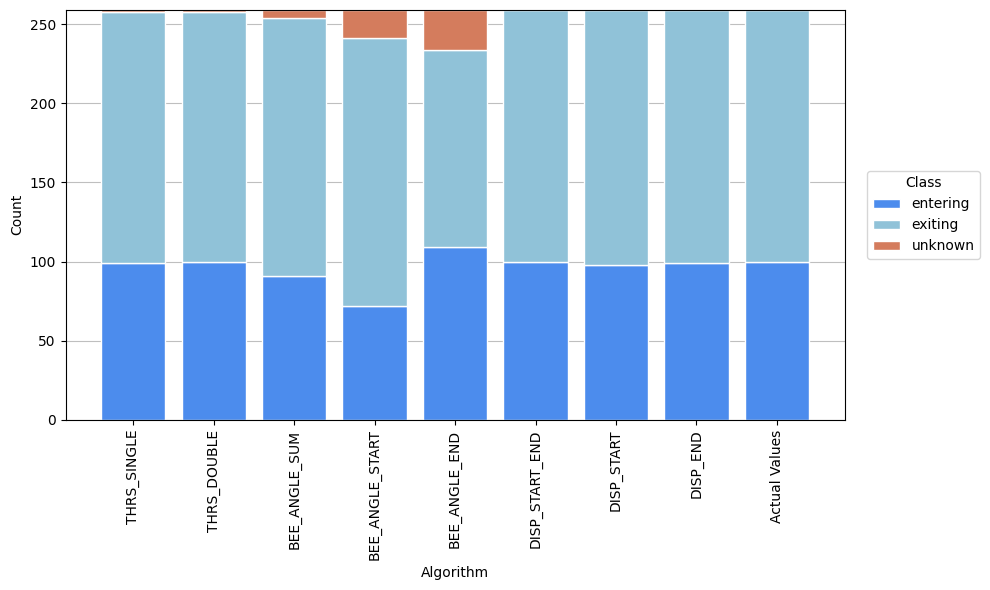

In [23]:
generate_dist(simple_matrix,"simple")

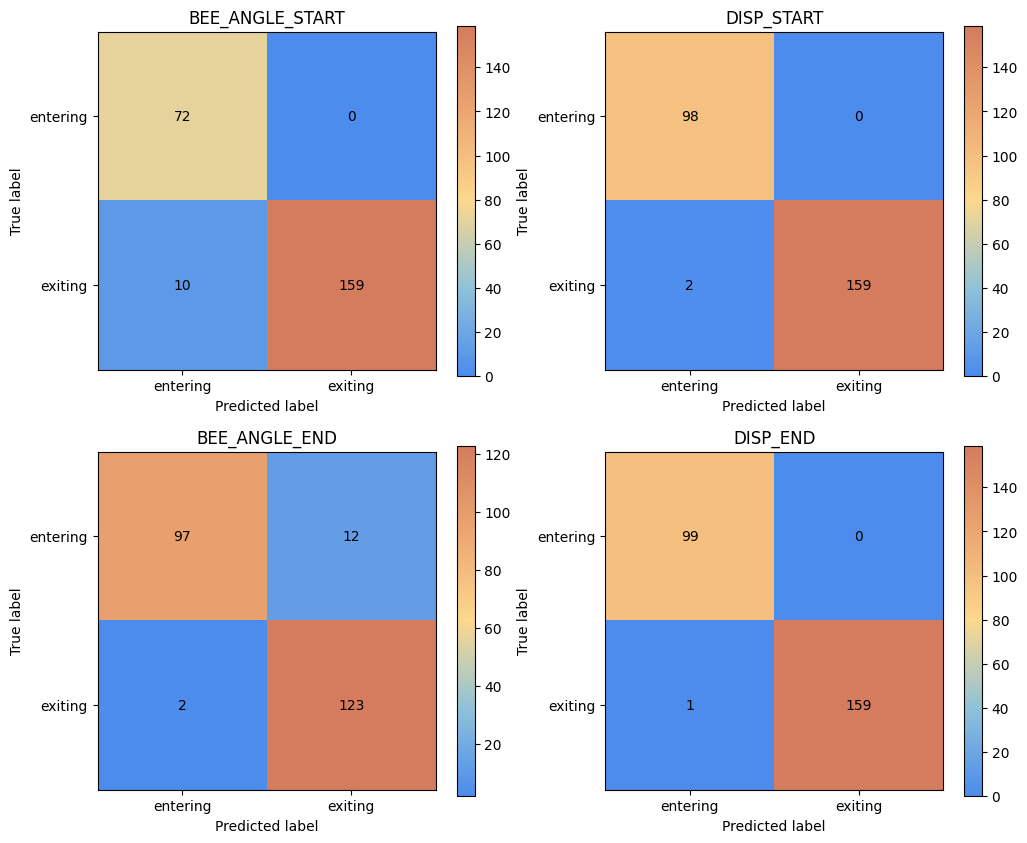

In [24]:
figure, axes = plt.subplots(2, 2,figsize=(12, 10))
cheatsheet1 = cheatsheet[~cheatsheet.event.isin(removed)]
columns = simple_matrix.drop(columns=['THRS_DOUBLE', 'DISP_START_END','BEE_ANGLE_SUM','THRS_SINGLE','Actual Values']).columns
for i in range(len(columns)):
    column = simple_matrix[columns[i]]
    cf_matrix = confusion_matrix(column, cheatsheet1['event'],labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
    disp.plot(ax=axes[i%2,i//2], cmap=cmap)
    axes[i%2, i//2].set_title(columns[i])

    for text in disp.text_.flat: 
        text.set_color('black') 

plt.show()
figure.savefig("confusion1.png",bbox_inches='tight') 

Unknown added as a third class

In [25]:
#compare classifications against ground truth

removed = ['unknown']
labels = ['entering','exiting', 'unknown']

cheatsheet3 = cheatsheet[~cheatsheet.event.isin(removed)].reset_index()
cheatsheet3['event'] = cheatsheet3['event'].apply(lambda x: x if x in labels else "unknown")

functions = {
    'THRS_DOUBLE': in_out,
    'THRS_SINGLE': in_out_single,
    'DISP_START_END': displacementinit,
    'BEE_ANGLE_SUM': angles,
    'DISP_START': displacement2,
    'DISP_END': displacement,
    'BEE_ANGLE_START': firstangle,
    'BEE_ANGLE_END': lastangle,
    
}

functions = {k: functions[k] for k in algo_order if k in functions}

for_matrix = {}

for APPROACHES, func in functions.items():
    for_matrix[APPROACHES] = []

for index, row in cheatsheet3.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['group_id'] == line]

    for APPROACHES, func in functions.items():
        result = func(detections)
        for_matrix[APPROACHES].append(result)
            
        

In [26]:
three_matrix = pd.DataFrame.from_dict(for_matrix)
score = calculate_scores(three_matrix,cheatsheet3['event'],labels)
three_dict = flatten_dict(score,labels)

C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

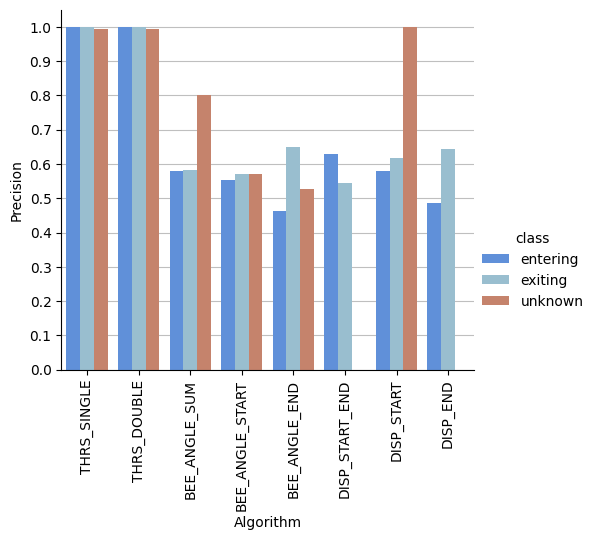

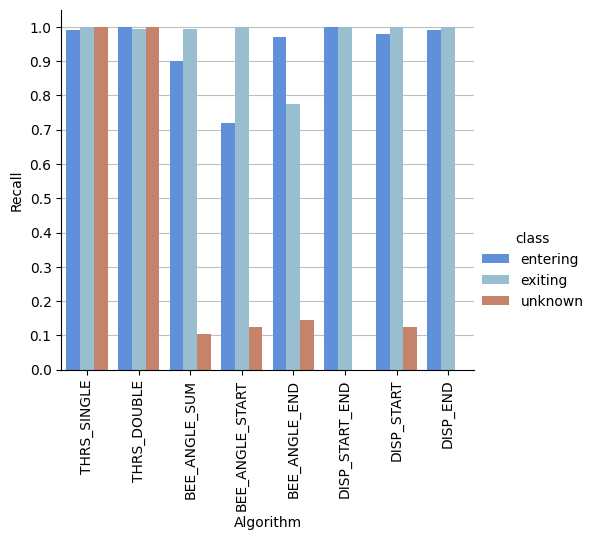

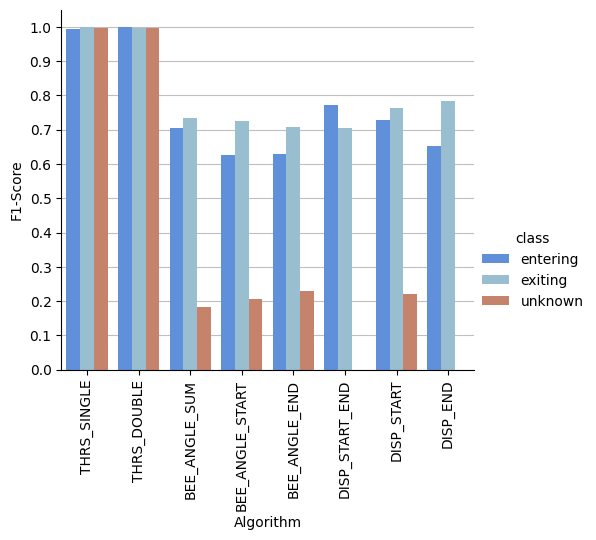

In [27]:
generate_sidegraphs(three_dict,"three")

C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

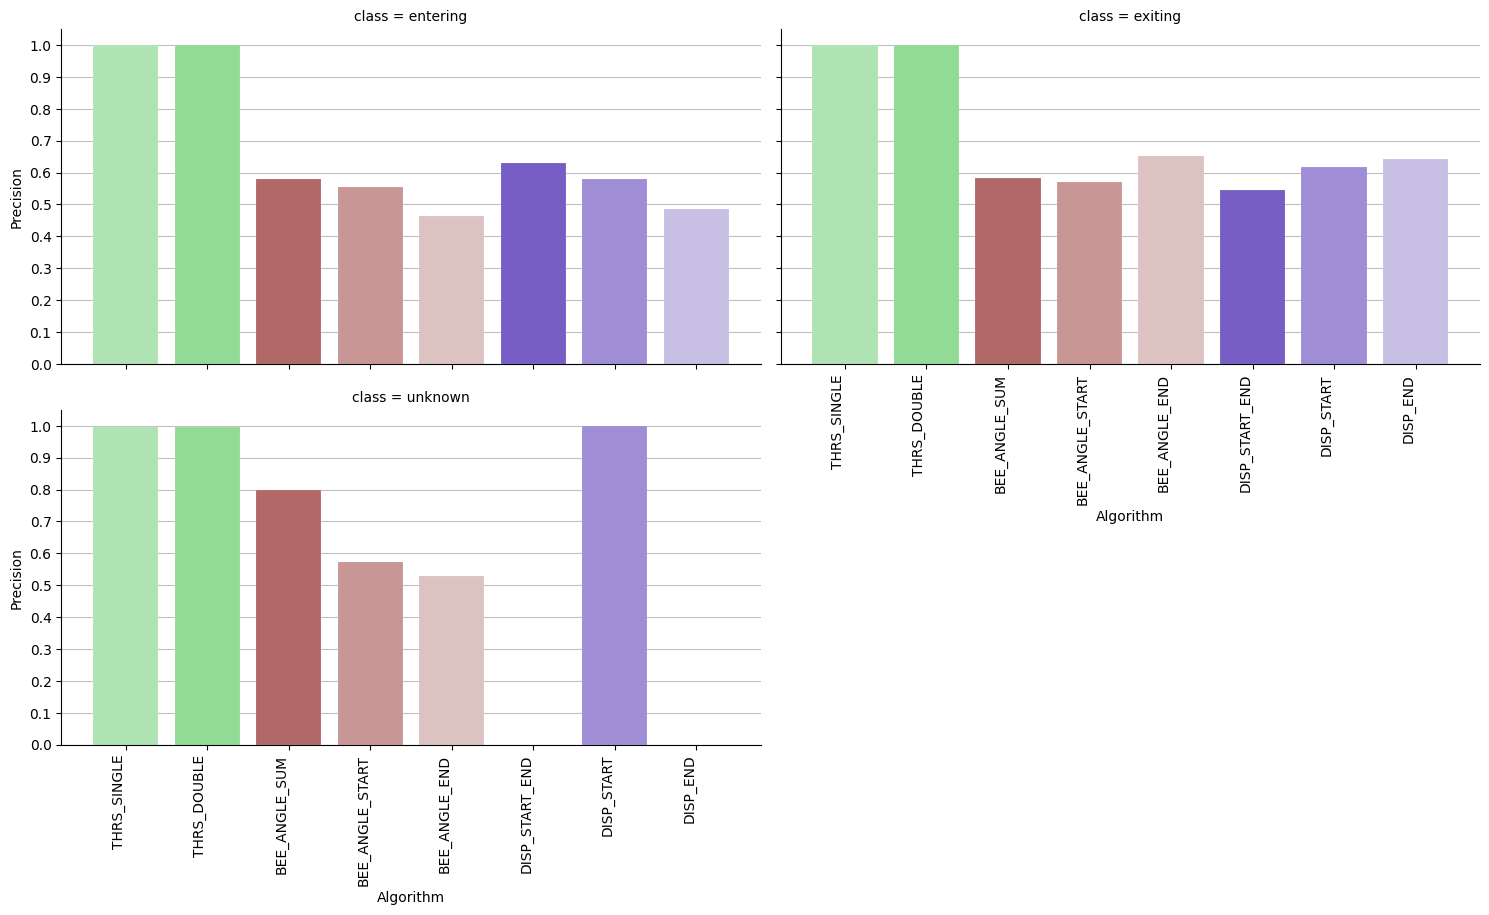

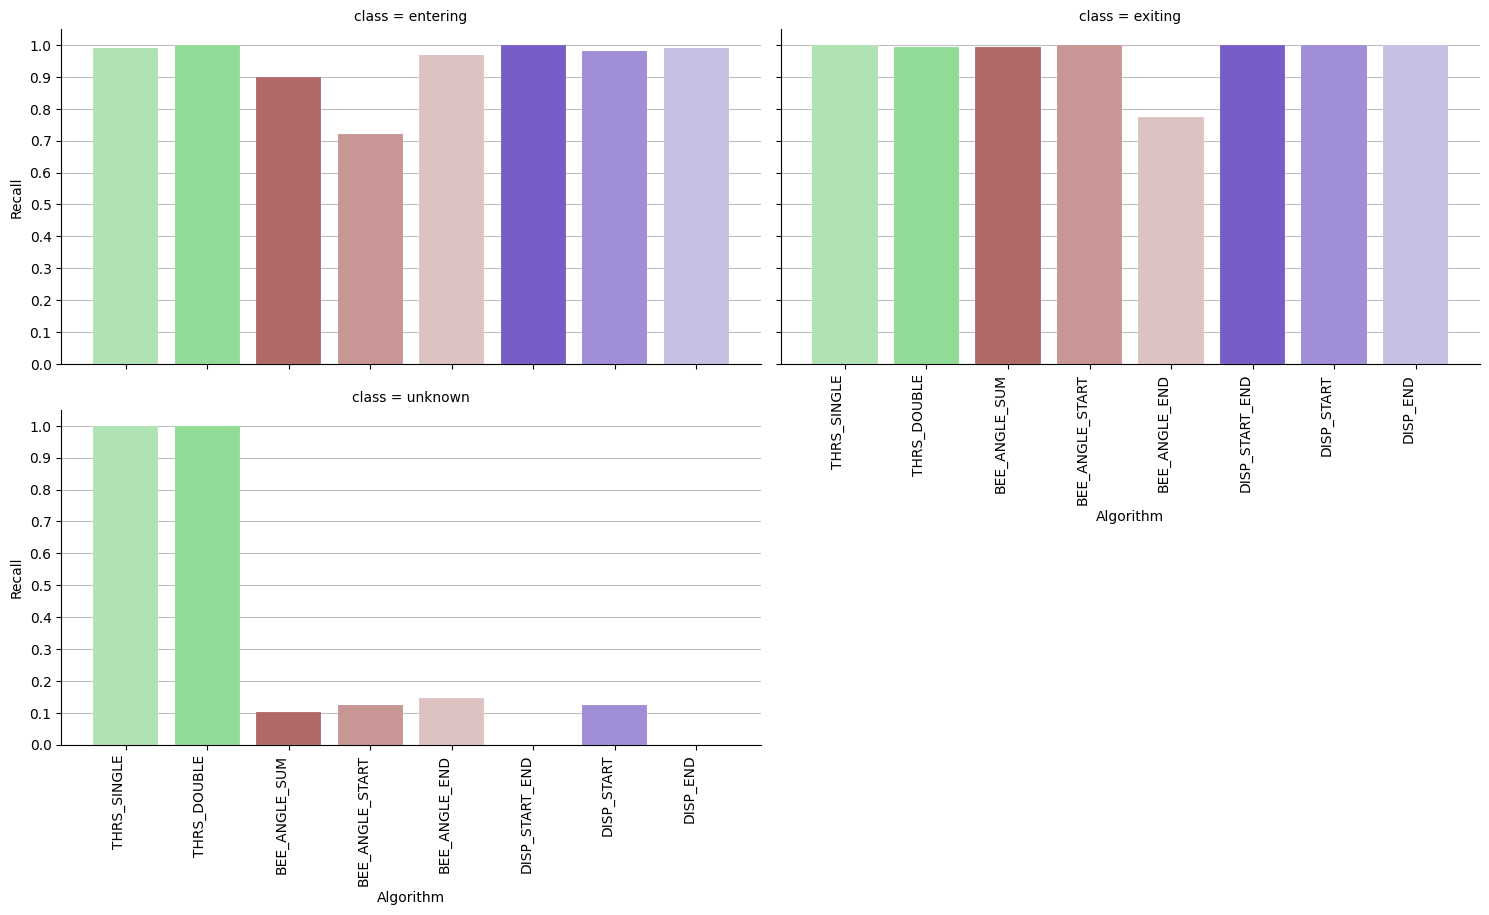

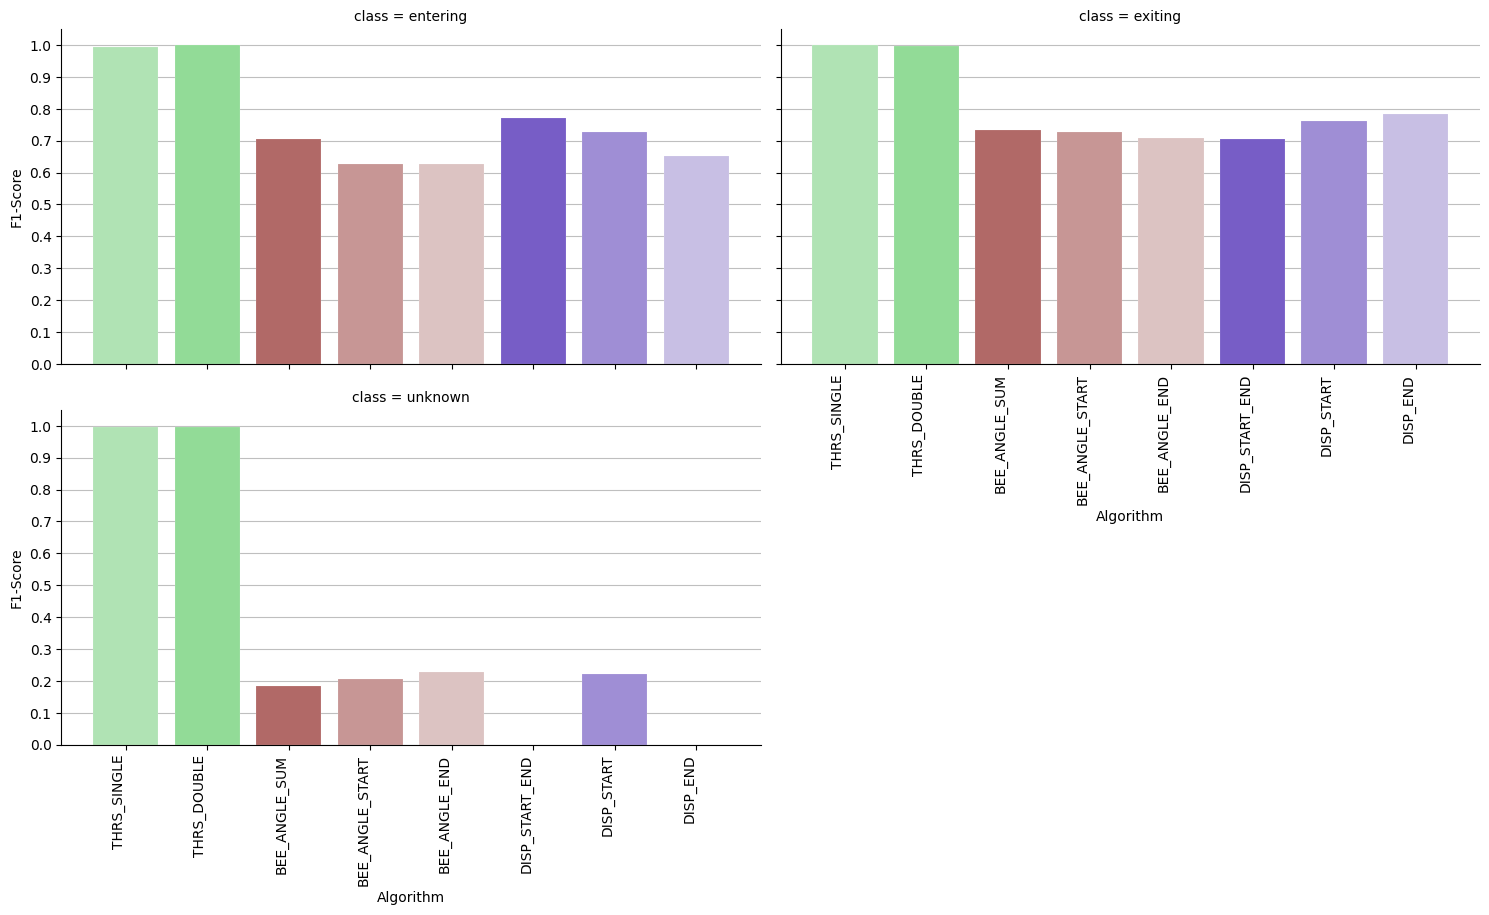

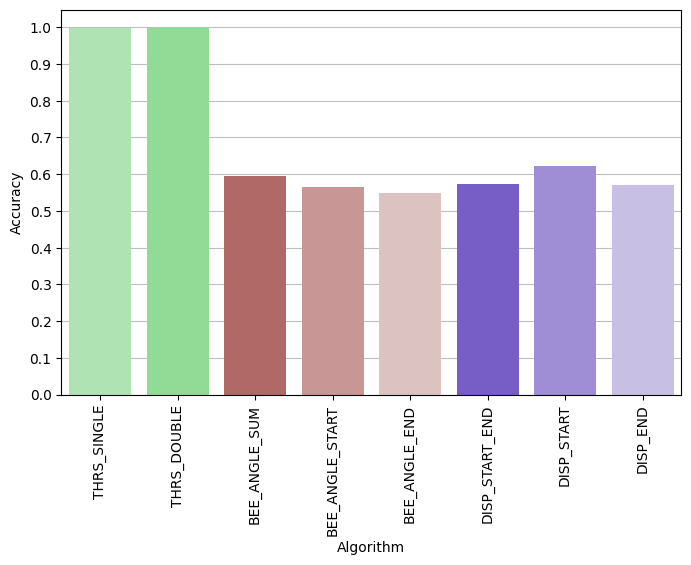

In [28]:
generate_graphs(three_dict,"three")

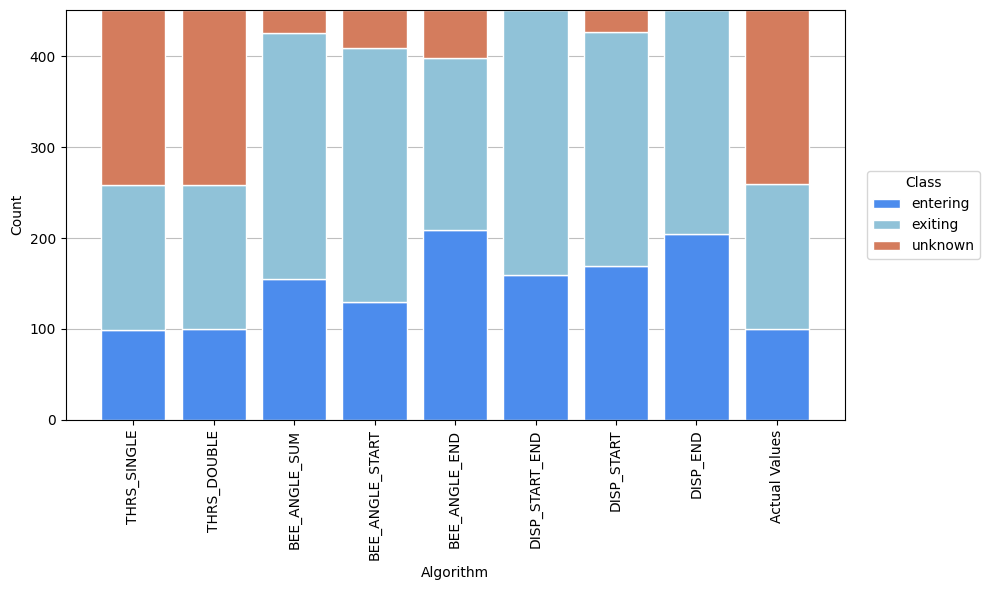

In [29]:
three_matrix['Actual Values'] = cheatsheet3['event']
generate_dist(three_matrix,"three")

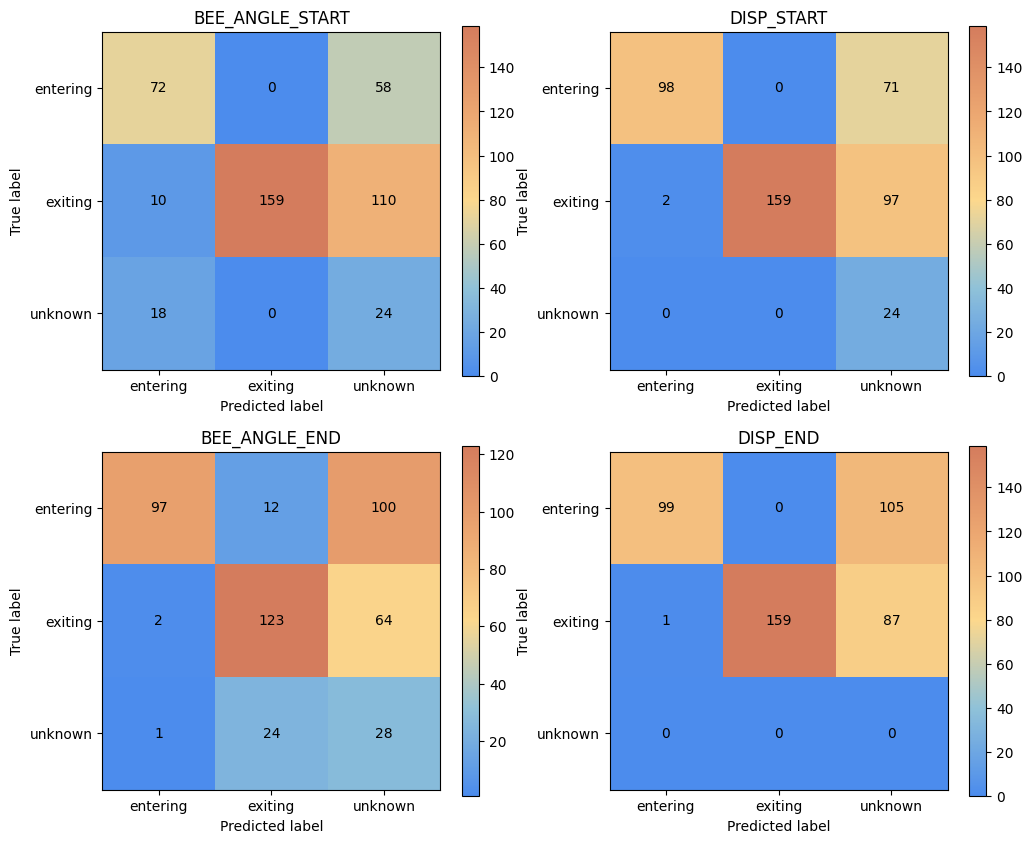

In [30]:
figure, axes = plt.subplots(2, 2,figsize=(12, 10))
columns = three_matrix.drop(columns=['THRS_DOUBLE', 'DISP_START_END','BEE_ANGLE_SUM','THRS_SINGLE','Actual Values']).columns
for i in range(len(columns)):
    column = three_matrix[columns[i]]
    cf_matrix = confusion_matrix(column, cheatsheet3['event'],labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
    disp.plot(ax=axes[i%2,i//2], cmap=cmap)
    axes[i%2, i//2].set_title(columns[i])

    for text in disp.text_.flat: 
        text.set_color('black') 

plt.show()
figure.savefig("confusion3.png",bbox_inches='tight') 

Compound cases

In [31]:
#cheatsheet of compound events
#compare classifications against ground truth

cheatsheet2 = cheatsheet[cheatsheet['event'] != 'unknown'].reset_index()
labels = ['entering','exiting','entering-exiting','exiting-entering']
for_matrix2 = {}

functions = {
    'THRS_BIDIRECTIONAL':in_out2,
    'DISP_BIDIRECTIONAL': displacementbackforth,
    'BEE_ANGLE_BIDIRECTIONAL': lastfirstangle  
}

functions = {k: functions[k] for k in algo_order if k in functions}

for APPROACHES, func in functions.items():
    for_matrix2[APPROACHES] = []
    
for index, row in cheatsheet2.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['group_id'] == line]

    unknowns = ['unknown-entering','unknown-exiting','exiting-unknown','entering-unknown']
    for APPROACHES, func in functions.items():
        result = func(detections)
        if result in unknowns:
            result = 'unknown'
        for_matrix2[APPROACHES].append(result)



In [32]:
compound_matrix = pd.DataFrame.from_dict(for_matrix2)
score = calculate_scores(compound_matrix,cheatsheet2['event'],labels)
compound_dict = flatten_dict(score,labels)

In [33]:
for col in compound_matrix:
    column = compound_matrix[col]
    print(col)
    print(classification_report(cheatsheet2['event'],column,labels=labels,target_names=labels))

THRS_BIDIRECTIONAL
                  precision    recall  f1-score   support

        entering       1.00      1.00      1.00       100
         exiting       1.00      0.99      1.00       159
entering-exiting       0.99      1.00      0.99        90
exiting-entering       1.00      0.99      1.00       102

       micro avg       1.00      1.00      1.00       451
       macro avg       1.00      1.00      1.00       451
    weighted avg       1.00      1.00      1.00       451

DISP_BIDIRECTIONAL
                  precision    recall  f1-score   support

        entering       0.96      0.97      0.97       100
         exiting       0.95      1.00      0.98       159
entering-exiting       0.99      0.74      0.85        90
exiting-entering       0.98      0.87      0.92       102

       micro avg       0.96      0.91      0.94       451
       macro avg       0.97      0.90      0.93       451
    weighted avg       0.97      0.91      0.94       451

BEE_ANGLE_BIDIRECTIONAL
    

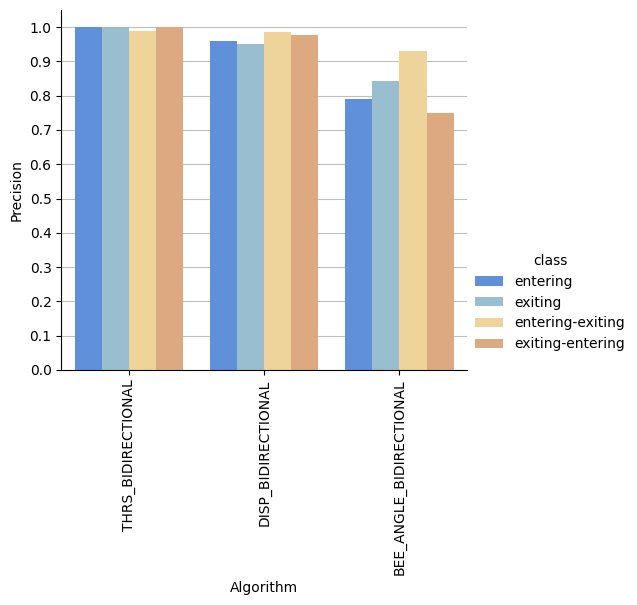

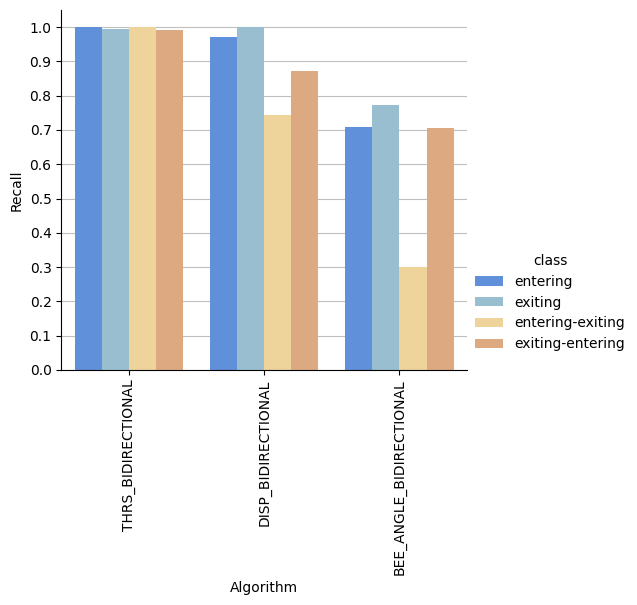

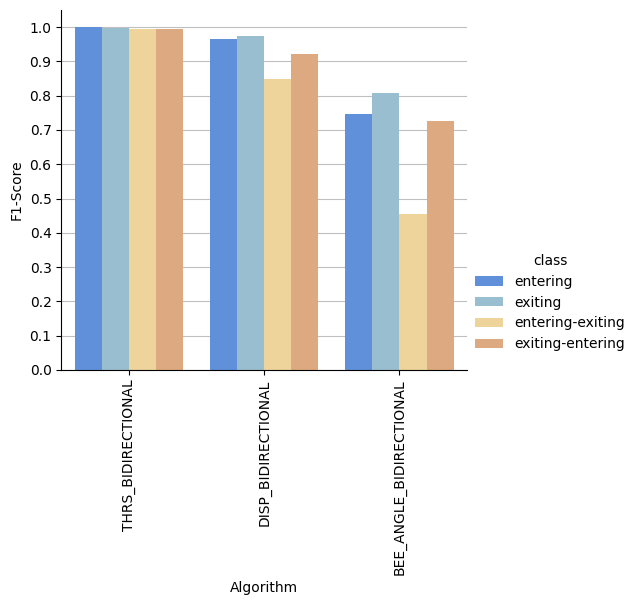

In [34]:
generate_sidegraphs(compound_dict,"compound")

C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

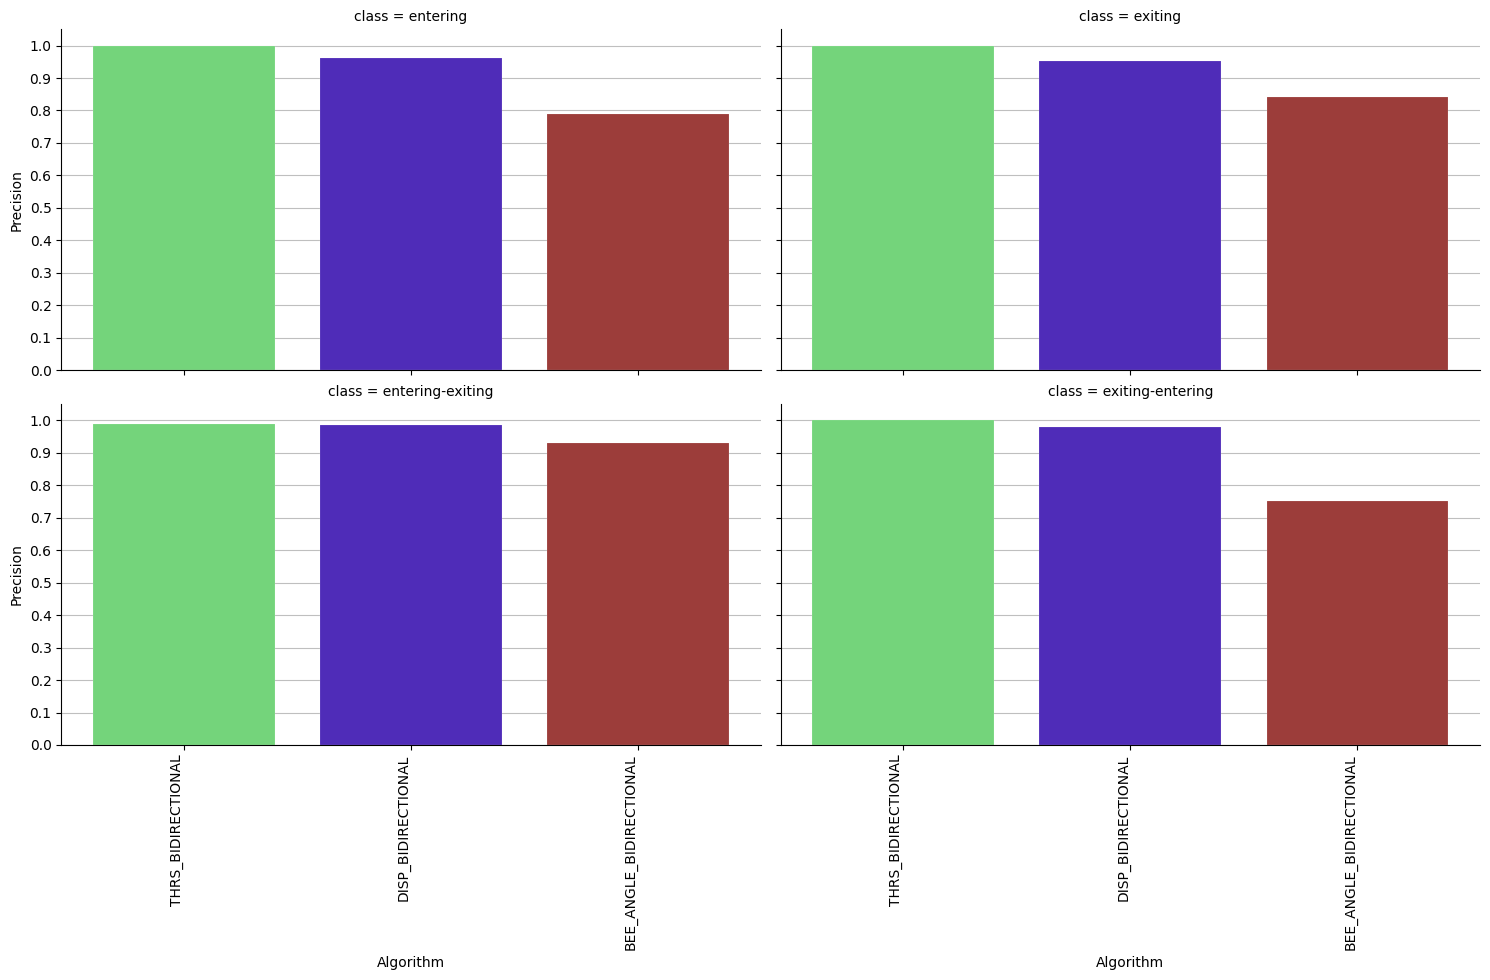

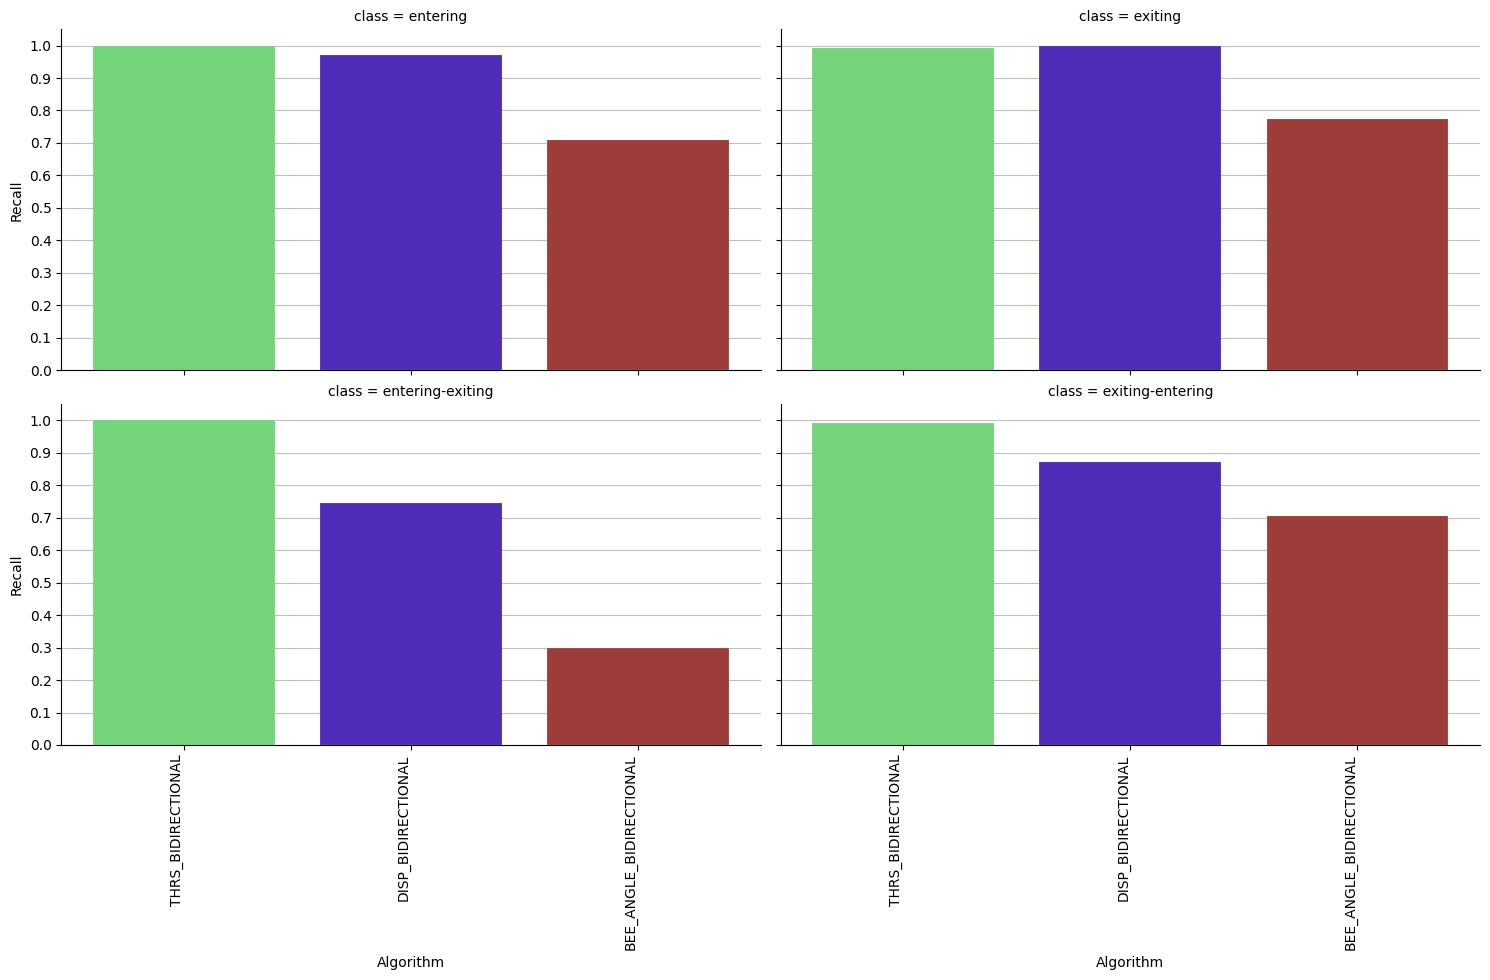

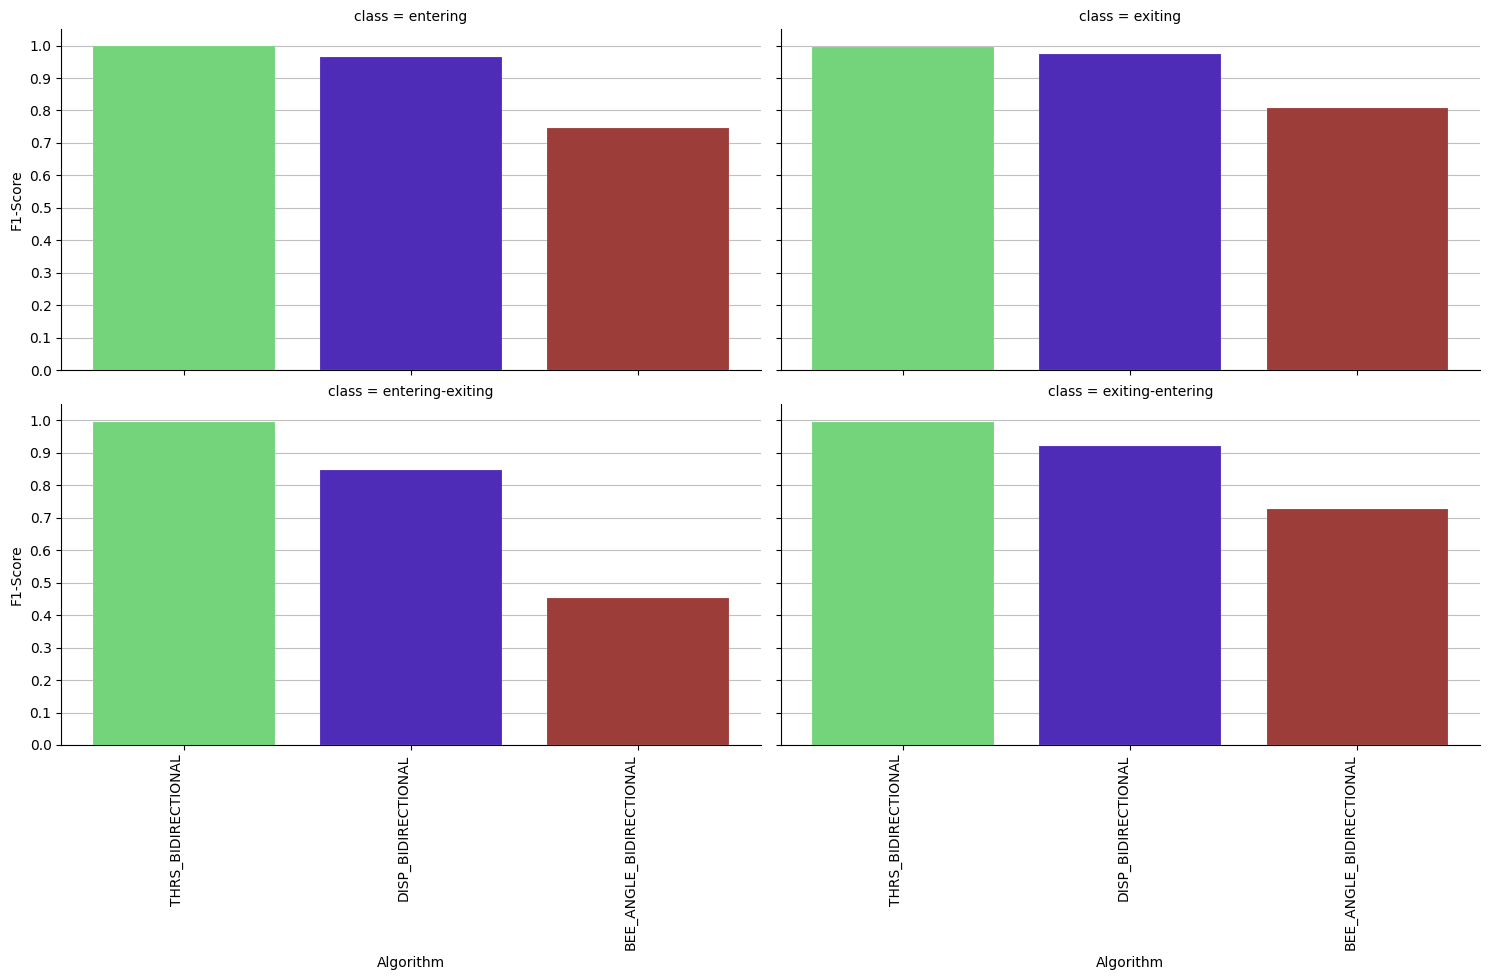

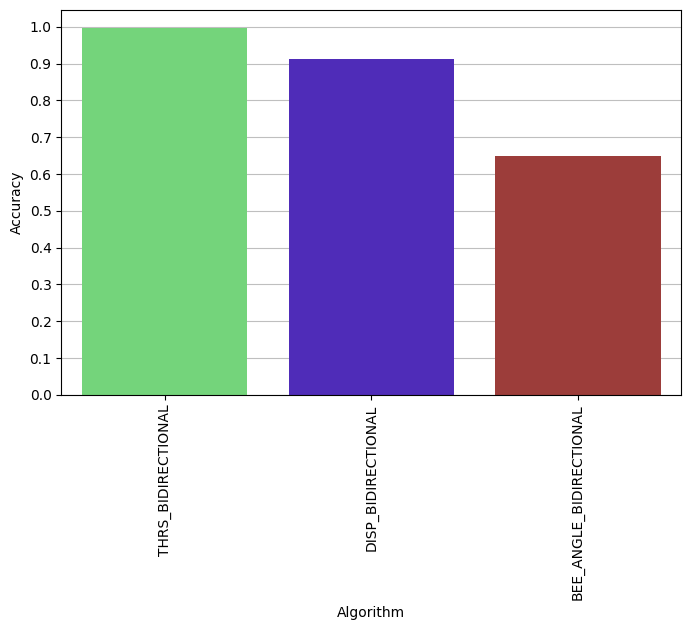

In [35]:
generate_graphs(compound_dict,"compound")

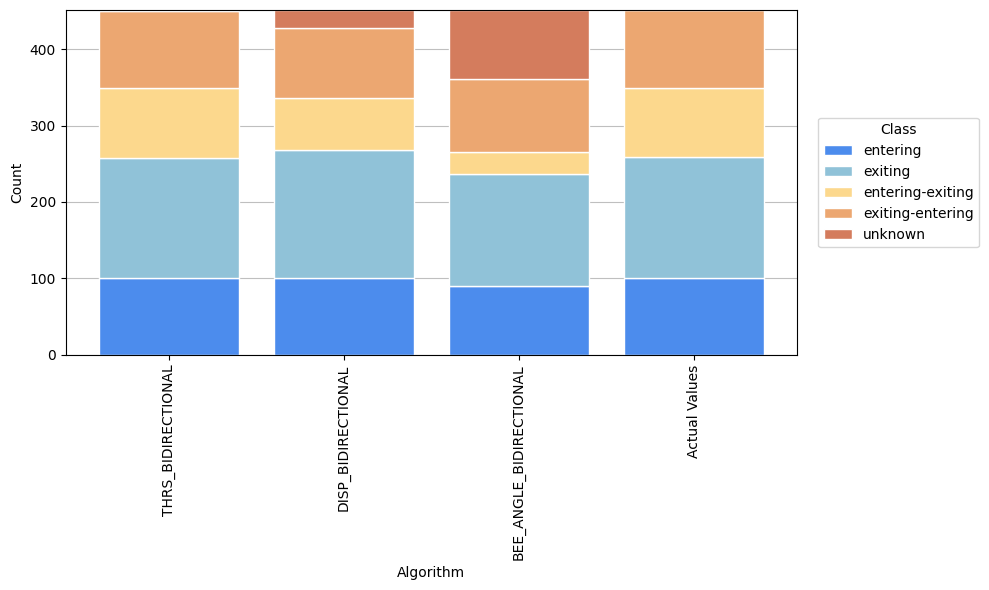

In [36]:
compound_matrix['Actual Values'] = cheatsheet2['event']
generate_dist(compound_matrix,"compound")

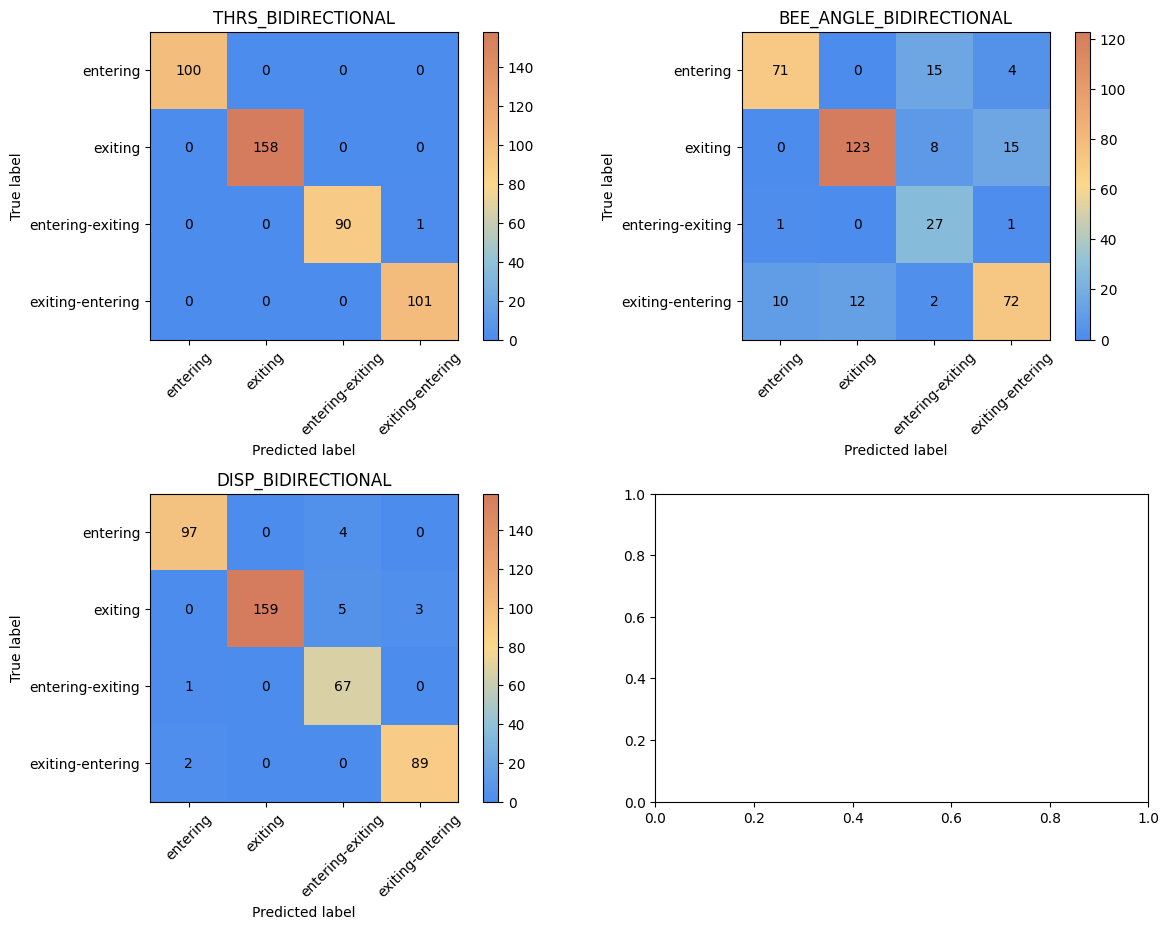

In [37]:
compound_matrix = pd.DataFrame.from_dict(for_matrix2)
figure, axes = plt.subplots(2, 2,figsize=(14, 10))
figure.subplots_adjust(hspace=0.5)
columns = compound_matrix.columns
for i in range(len(columns)):
    column = compound_matrix[columns[i]]
    cf_matrix = confusion_matrix(column, cheatsheet2['event'],labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
    disp.plot(ax=axes[i%2,i//2],cmap=cmap)
    axes[i%2, i//2].set_title(columns[i])
    axes[i % 2, i // 2].tick_params(axis='x', labelrotation=45)
    for text in disp.text_.flat: 
        text.set_color('black') 
plt.show()
figure.savefig("confusion2.png")

## DIVERGENCE SCORE

Tested on regular simple cases

In [38]:
APPROACHES_names = ['THRS_DOUBLE', 'THRS_SINGLE','DISP_START_END', 'BEE_ANGLE_SUM','DISP_START','DISP_END', 
              'BEE_ANGLE_START','BEE_ANGLE_END']
complement = {APPROACHES: {rr: 0 for rr in APPROACHES_names} for APPROACHES in APPROACHES_names}
for index, row in cheatsheet1.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['group_id'] == line]
    #APPROACHESs
    APPROACHESs = {
    'THRS_DOUBLE': in_out(detections),
    'THRS_SINGLE': in_out_single(detections),
    'DISP_START_END': displacementinit(detections),
    'BEE_ANGLE_SUM': angles(detections),
    'DISP_START': displacement2(detections),
    'DISP_END': displacement(detections),    
    'BEE_ANGLE_START': firstangle(detections),
    'BEE_ANGLE_END': lastangle(detections),
    }

    for key, value in APPROACHESs.items():
        for otherAPPROACHES, othervalue in APPROACHESs.items():
            #compare if APPROACHES's classification is different from previous APPROACHES
            if otherAPPROACHES != key and othervalue != value:
                complement[key][otherAPPROACHES] += 1
   


In [39]:
#X axis -> Y axis
df = pd.DataFrame.from_dict(complement).transpose()/len(cheatsheet1)
df
mask = np.triu(np.ones(df.shape, dtype=bool))

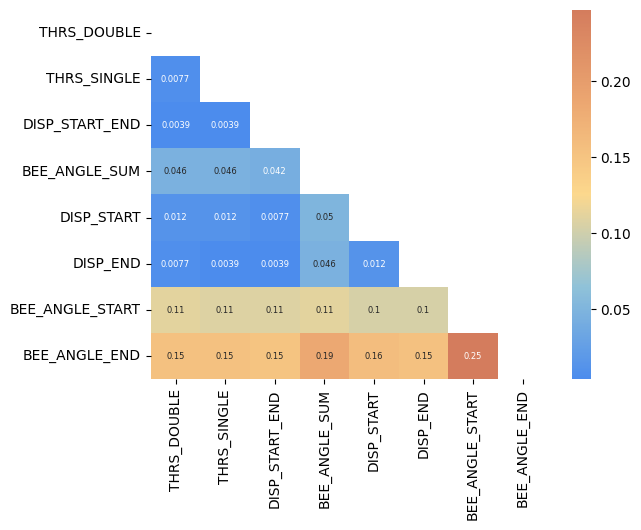

In [40]:
plot = sns.heatmap(df, annot=True,annot_kws={"size": 6}, mask=mask,cmap=cmap)
fig = plot.get_figure()
fig.savefig("divergencescore1.png",bbox_inches='tight') 

Cheatsheet with compound cases

In [41]:
APPROACHES_names = ['THRS_BIDIRECTIONAL','DISP_BIDIRECTIONAL','BEE_ANGLE_BIDIRECTIONAL' ]
complement = {APPROACHES: {rr: 0 for rr in APPROACHES_names} for APPROACHES in APPROACHES_names}
for index, row in cheatsheet2.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['group_id'] == line]
    #APPROACHESs
    APPROACHESs = {
    'THRS_BIDIRECTIONAL':in_out2(detections),
    'DISP_BIDIRECTIONAL':displacementbackforth(detections),
    'BEE_ANGLE_BIDIRECTIONAL':lastfirstangle(detections)
    }

    for key, value in APPROACHESs.items():
        for otherAPPROACHES, othervalue in APPROACHESs.items():
            if otherAPPROACHES != key and othervalue != value:
                complement[key][otherAPPROACHES] += 1
   


In [42]:
df = pd.DataFrame.from_dict(complement).transpose()/len(cheatsheet2)
df
mask = np.triu(np.ones(df.shape, dtype=bool))

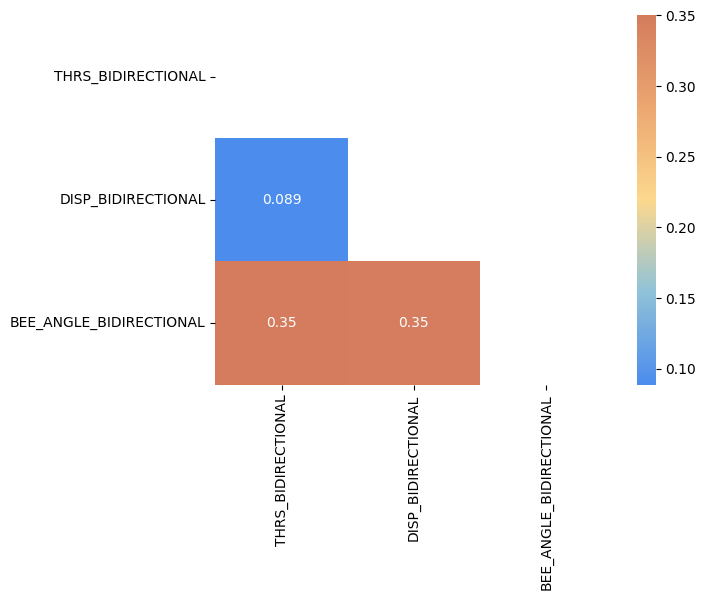

In [43]:
plot = sns.heatmap(df, annot=True,mask=mask,cmap = cmap)
fig = plot.get_figure()
fig.savefig("divergencescore2.png",bbox_inches='tight') 

## Global precision and accuracy

## GLOBAL ACCURACY

Considering only 3 classes (entering, exiting, unknown)

In [44]:
#compare classifications against ground truth

removed = ['unknown']
labels = ['entering','exiting', 'unknown']

cheatsheet3 = cheatsheet[~cheatsheet.event.isin(removed)].reset_index()
cheatsheet3['event'] = cheatsheet3['event'].apply(lambda x: x if x in labels else "unknown")

functions = {
    'THRS_DOUBLE': in_out,
    'THRS_SINGLE': in_out_single,
    'DISP_START_END': displacementinit,
    'BEE_ANGLE_SUM': angles,
    'THRS_BIDIRECTIONAL':in_out2,
    'DISP_START': displacement2,
    'DISP_END': displacement,
    'BEE_ANGLE_START': firstangle,
    'BEE_ANGLE_END': lastangle,
    'DISP_BIDIRECTIONAL': displacementbackforth,
    'BEE_ANGLE_BIDIRECTIONAL': lastfirstangle  
}
functions = {k: functions[k] for k in algo_order if k in functions}

for_matrix = {}

for APPROACHES, func in functions.items():
    for_matrix[APPROACHES] = []

for index, row in cheatsheet3.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['group_id'] == line]

    unknowns = ['unknown-entering','unknown-exiting','exiting-unknown','entering-unknown','entering-exiting','exiting-entering']
    for APPROACHES, func in functions.items():
        result = func(detections)
        if result in unknowns:
            result = 'unknown'
        for_matrix[APPROACHES].append(result)
            
        

In [45]:
global3_matrix = pd.DataFrame.from_dict(for_matrix)
score = calculate_scores(global3_matrix,cheatsheet3['event'],labels)
global3_dict = flatten_dict(score,labels)

C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

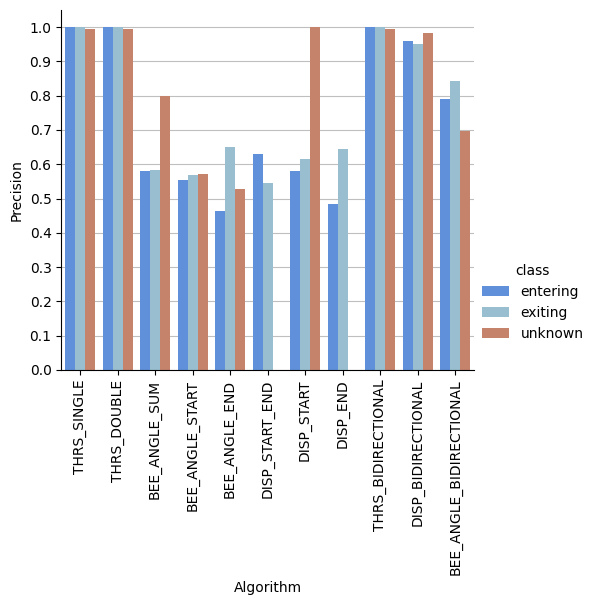

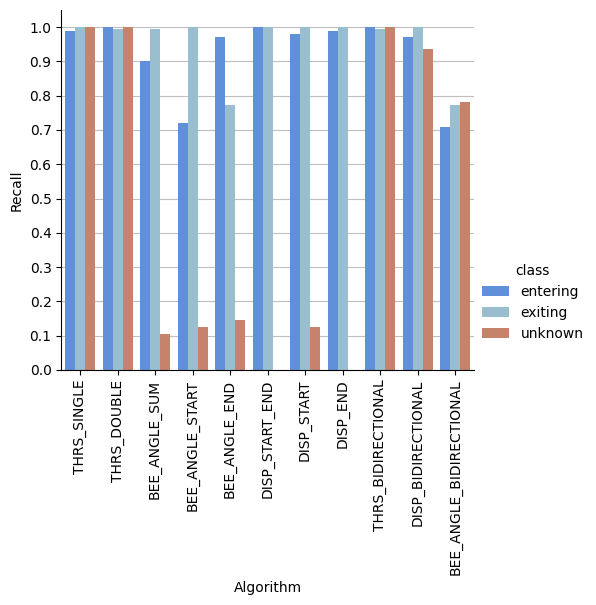

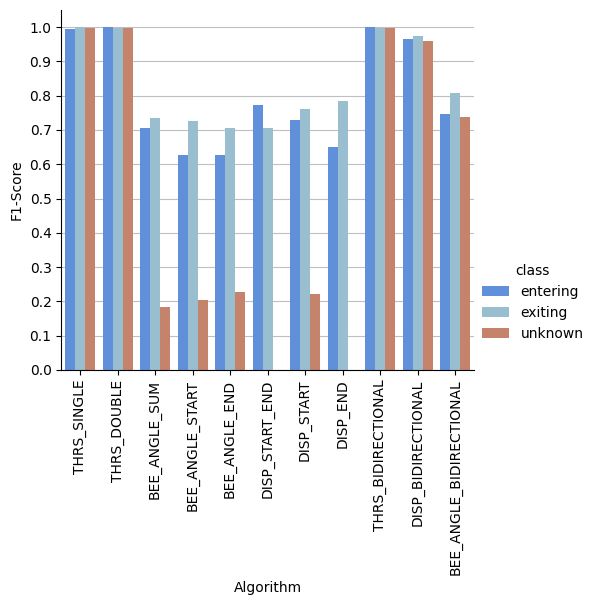

In [46]:
generate_sidegraphs(global3_dict,"global3")

C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

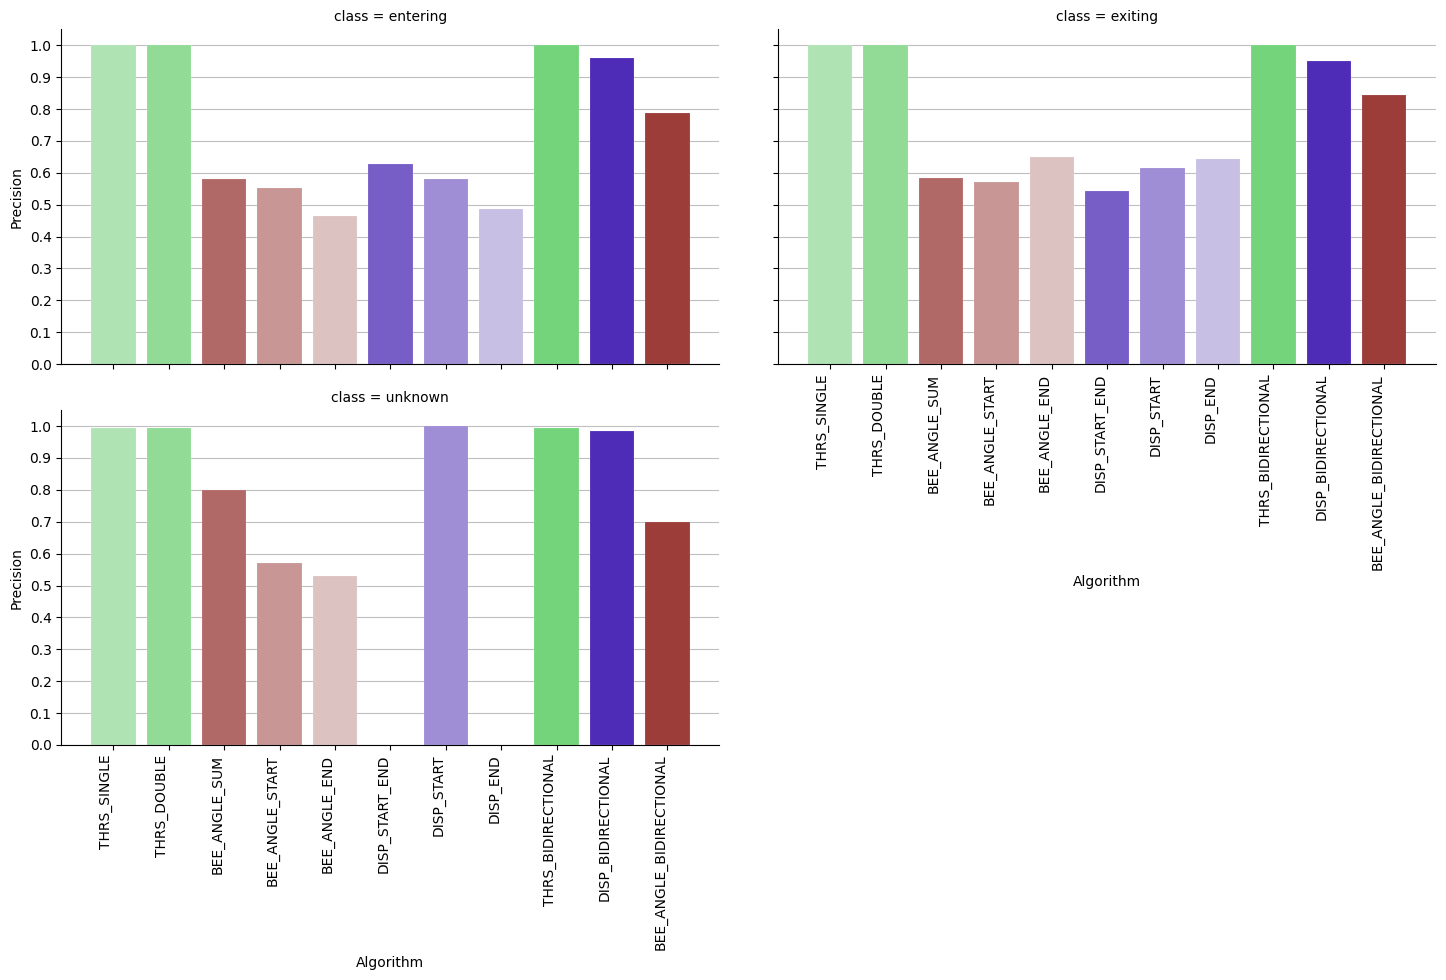

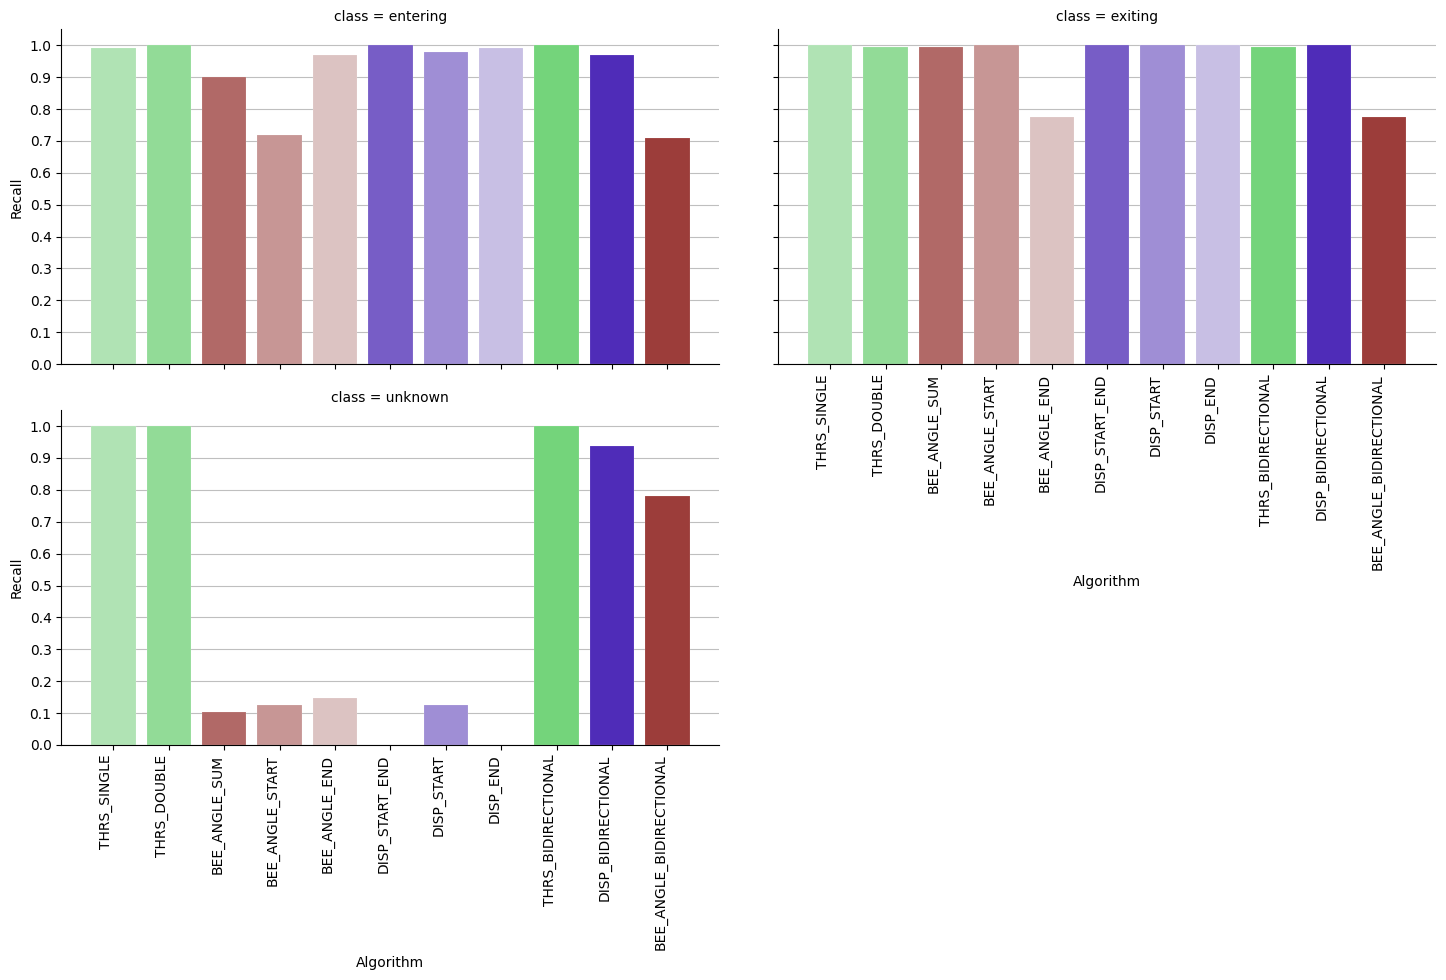

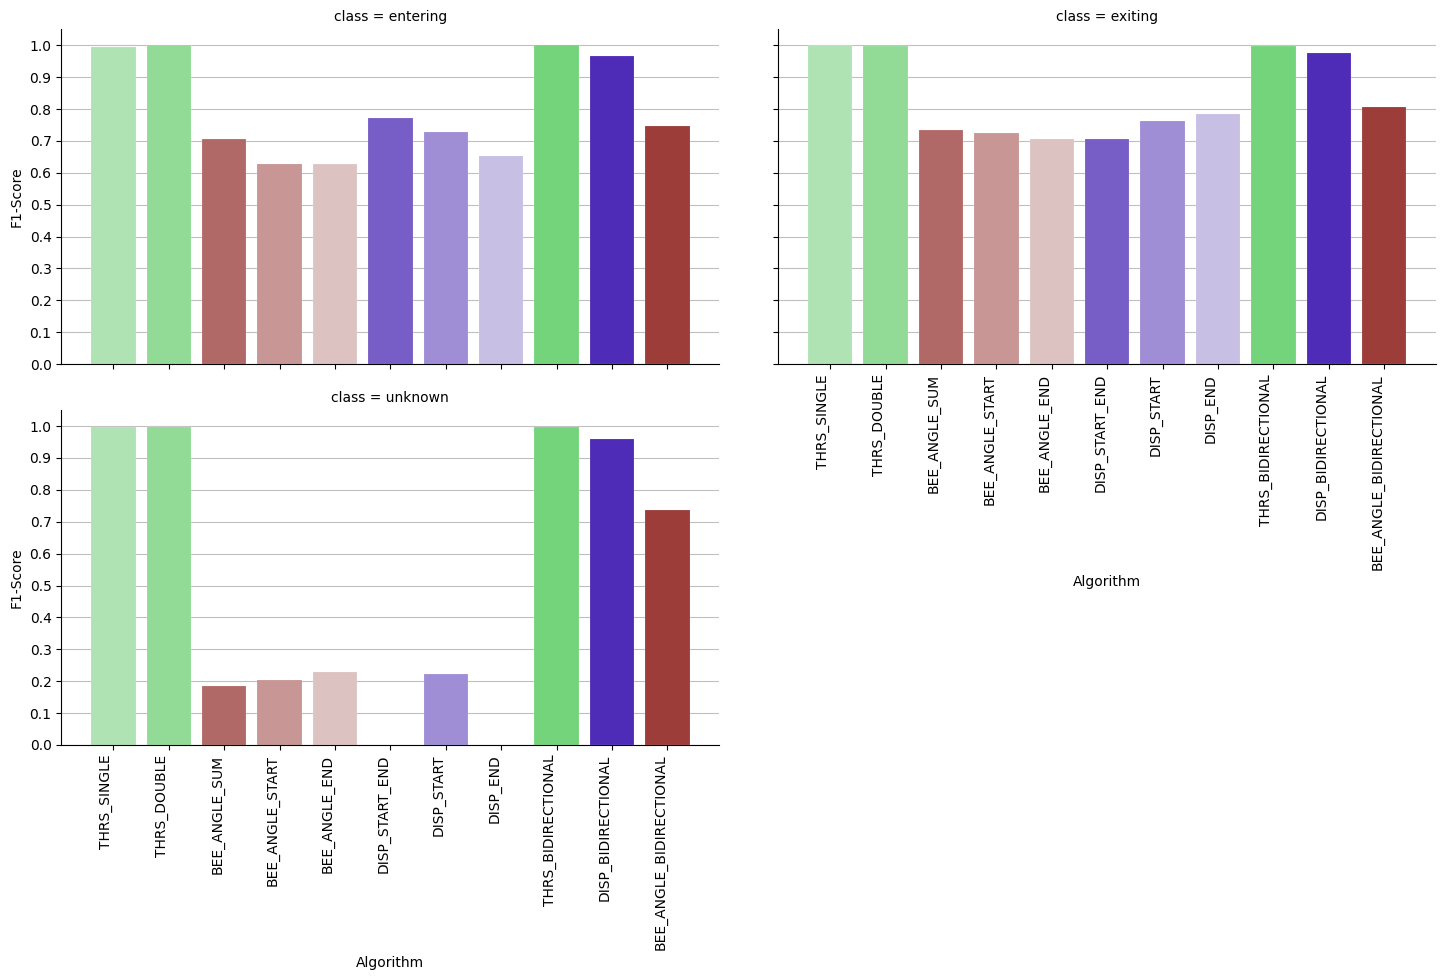

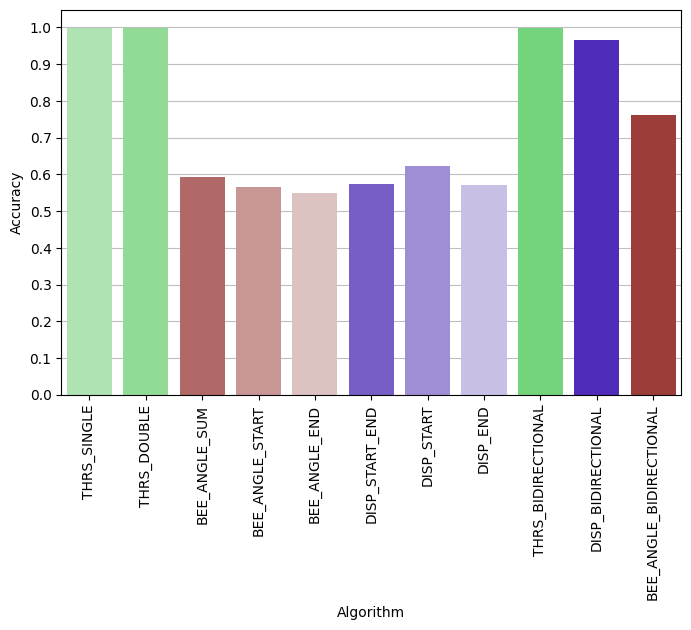

In [47]:
generate_graphs(global3_dict,"global3")

In [48]:
global3_matrix['Actual Values'] = cheatsheet3['event']

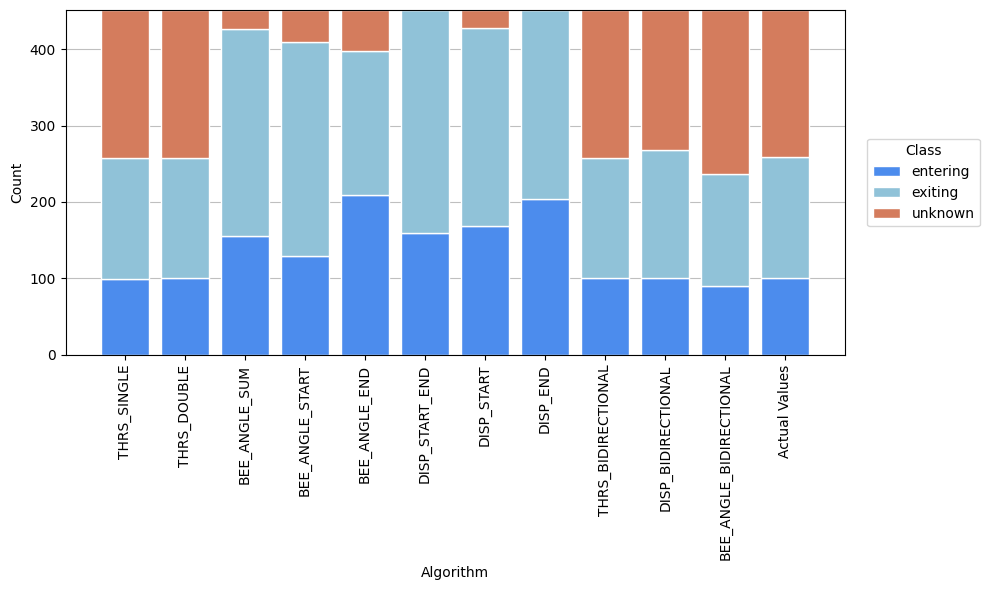

In [49]:
generate_dist(global3_matrix,"global3")

Considering full U-turn classes

In [50]:
#cheatsheet of compound events
#compare classifications against ground truth

cheatsheet2 = cheatsheet[cheatsheet['event'] != 'unknown'].reset_index()
labels = ['entering','exiting','entering-exiting','exiting-entering']
for_matrix2 = {}

functions = {
    'THRS_DOUBLE': in_out,
    'THRS_SINGLE': in_out_single,
    'DISP_START_END': displacementinit,
    'BEE_ANGLE_SUM': angles,
    'THRS_BIDIRECTIONAL':in_out2,
    'DISP_START': displacement2,
    'DISP_END': displacement,
    'BEE_ANGLE_START': firstangle,
    'BEE_ANGLE_END': lastangle,
    'DISP_BIDIRECTIONAL': displacementbackforth,
    'BEE_ANGLE_BIDIRECTIONAL': lastfirstangle  
}
functions = {k: functions[k] for k in algo_order if k in functions}

for APPROACHES, func in functions.items():
    for_matrix2[APPROACHES] = []
    
for index, row in cheatsheet2.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['group_id'] == line]

    unknowns = ['unknown-entering','unknown-exiting','exiting-unknown','entering-unknown']
    for APPROACHES, func in functions.items():
        result = func(detections)
        if result in unknowns:
            result = 'unknown'
        for_matrix2[APPROACHES].append(result)



In [51]:
global_matrix = pd.DataFrame.from_dict(for_matrix2)
score = calculate_scores(global_matrix,cheatsheet2['event'],labels)
global_dict = flatten_dict(score,labels)

C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
C:\Users\kashi\AppData\Local\Temp\ipykernel_12732\3623321980.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

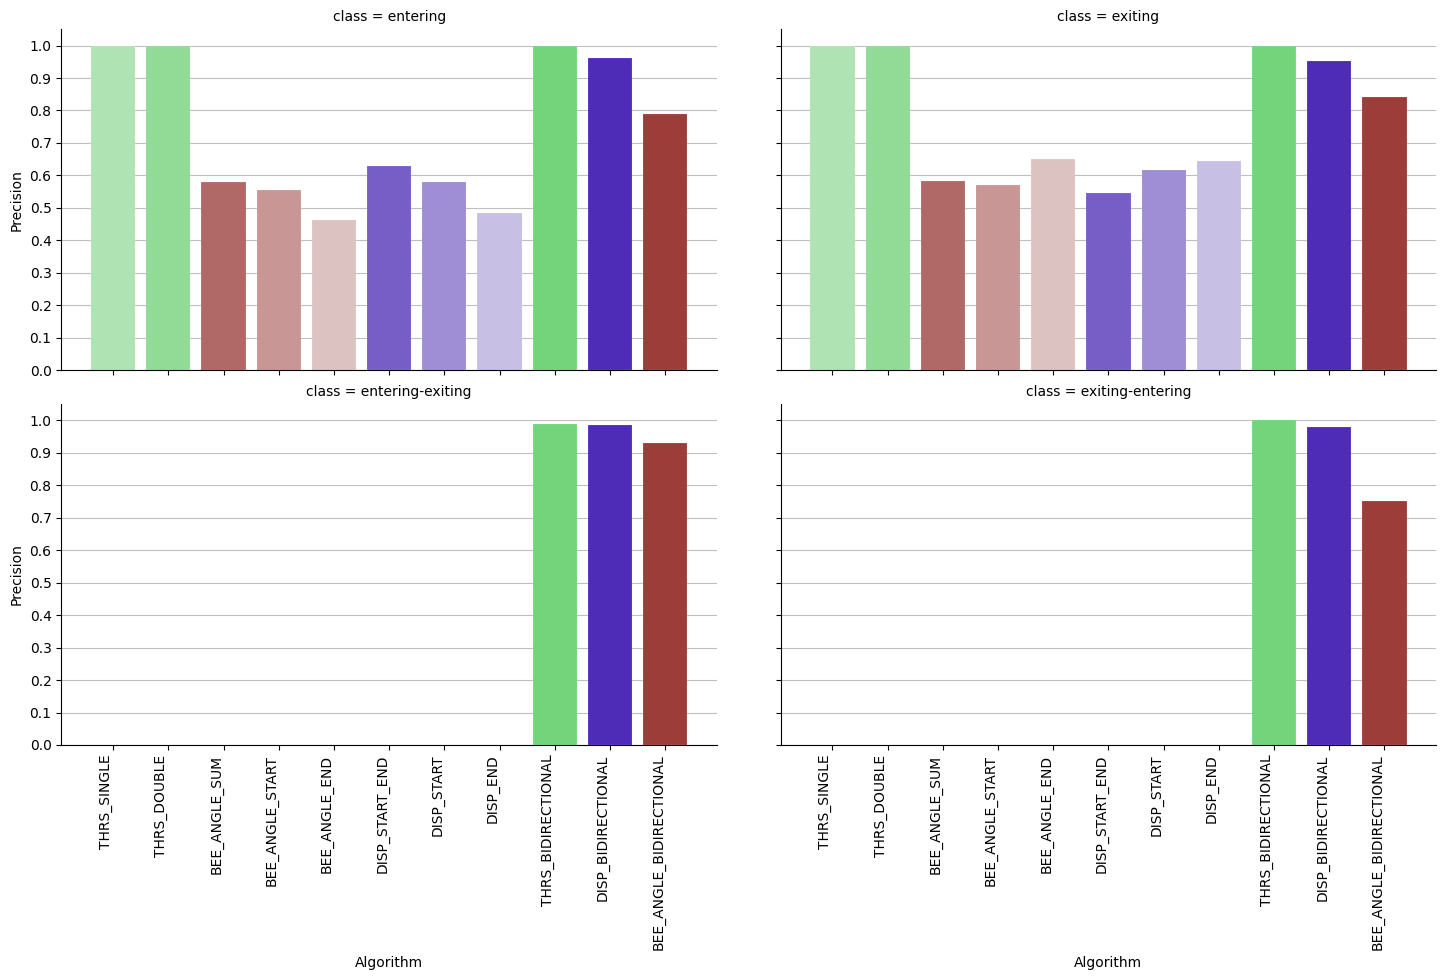

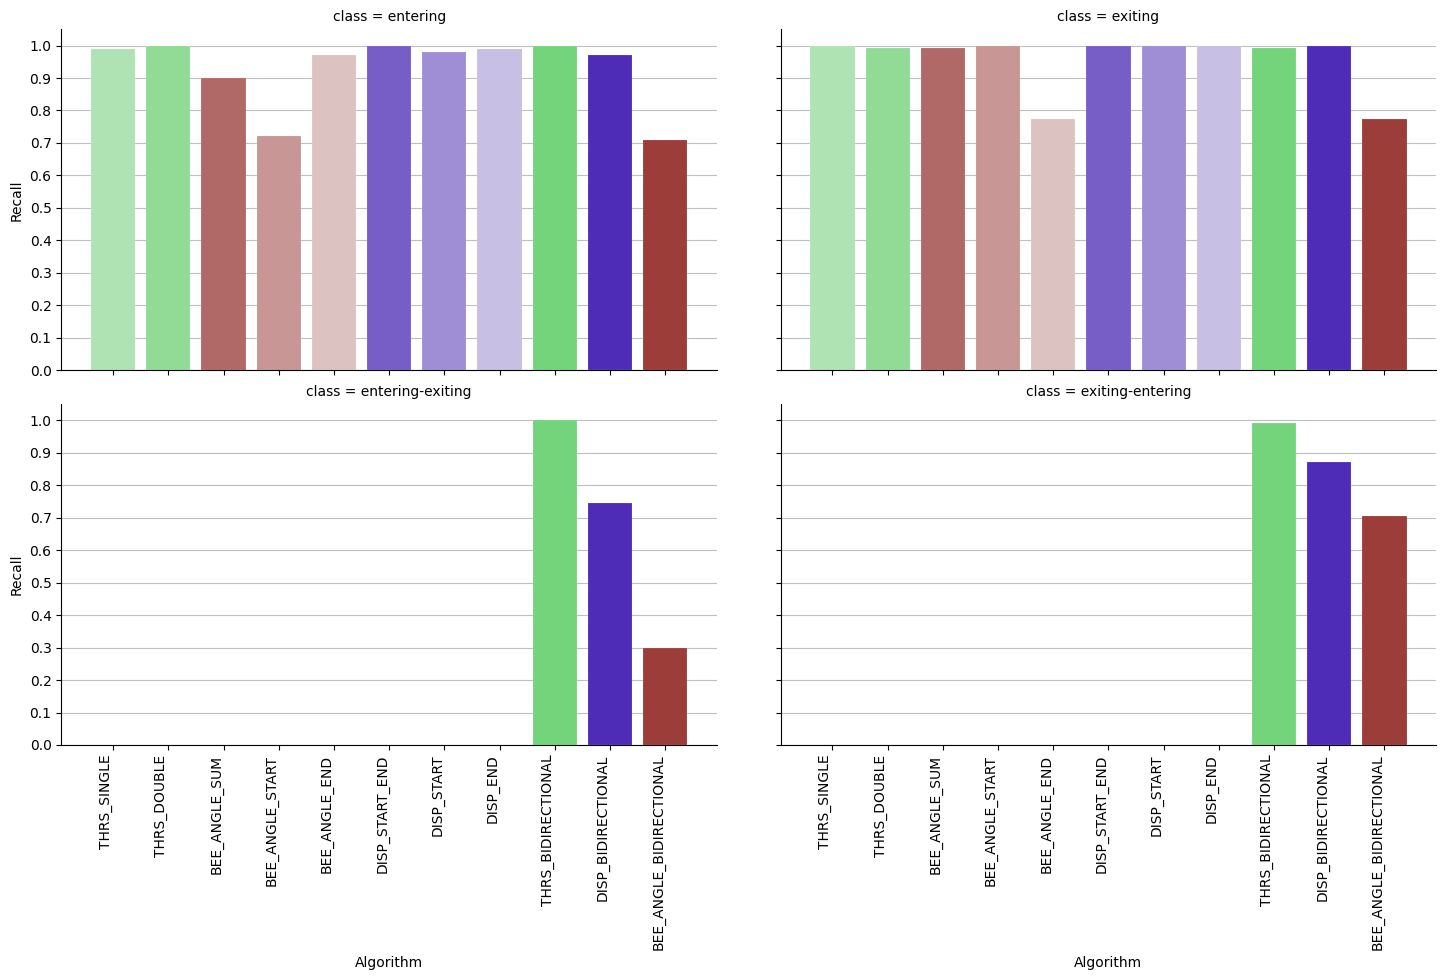

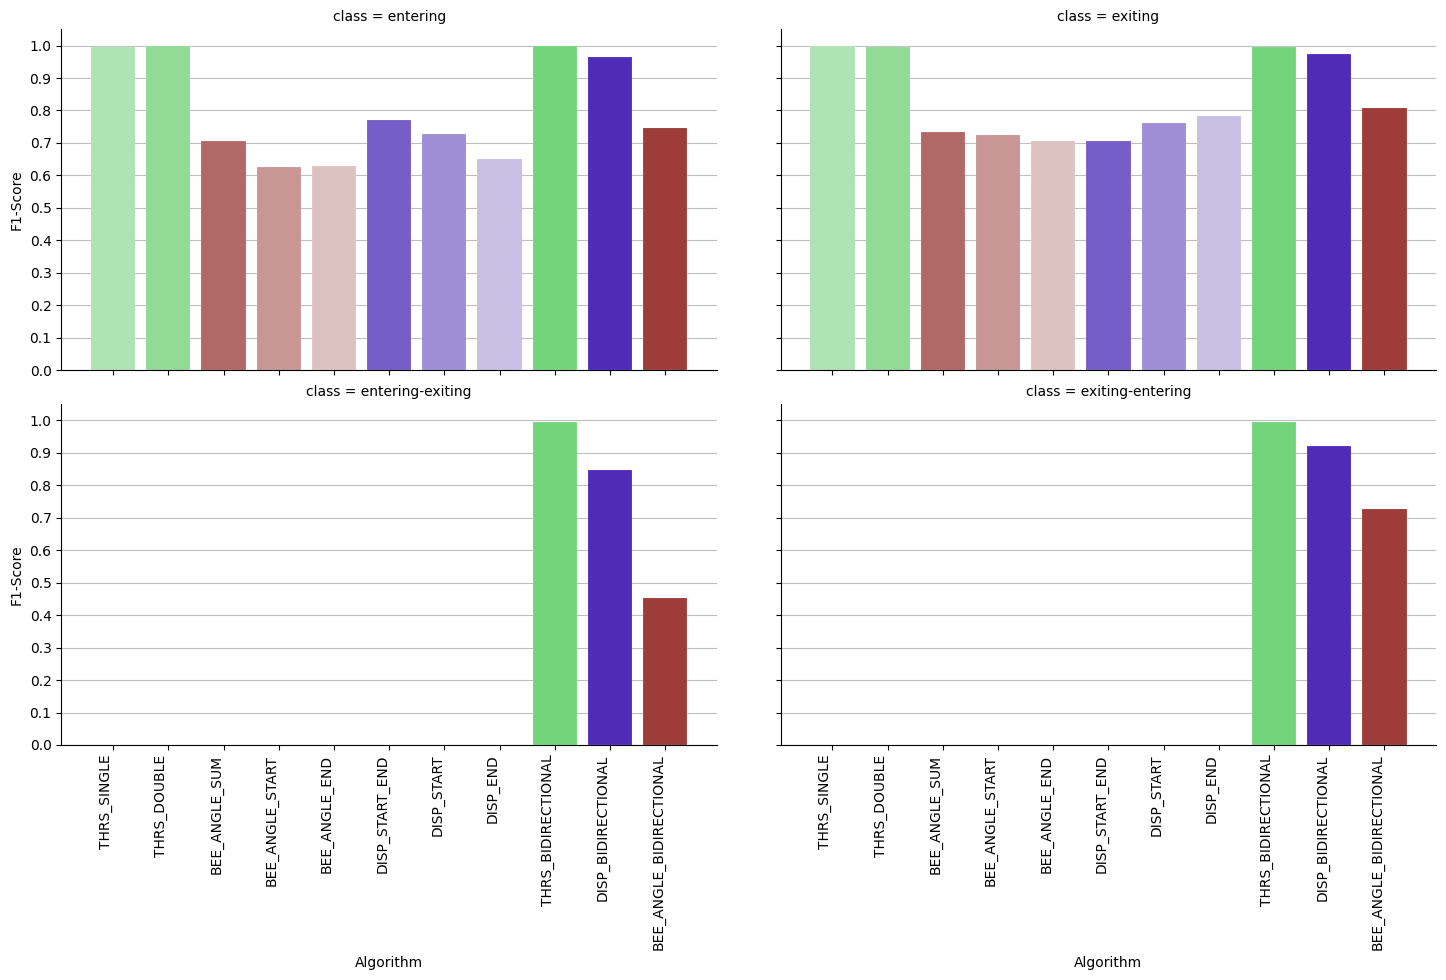

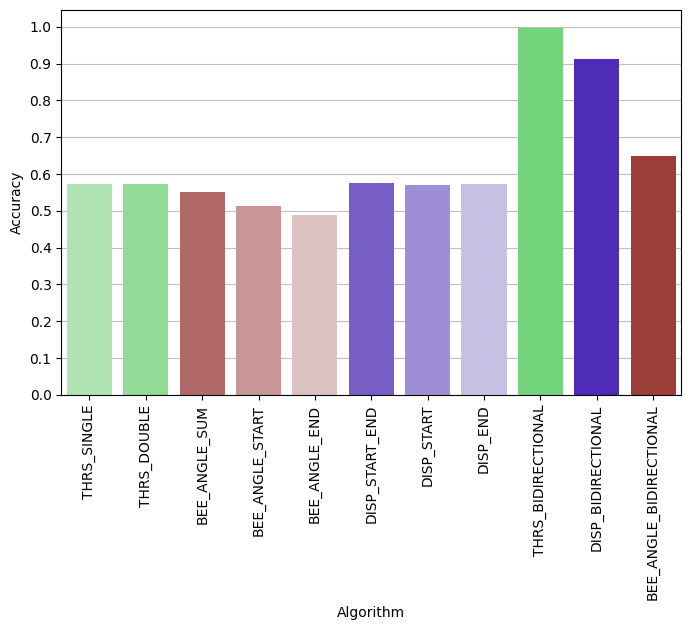

In [52]:
generate_graphs(global_dict,"global")

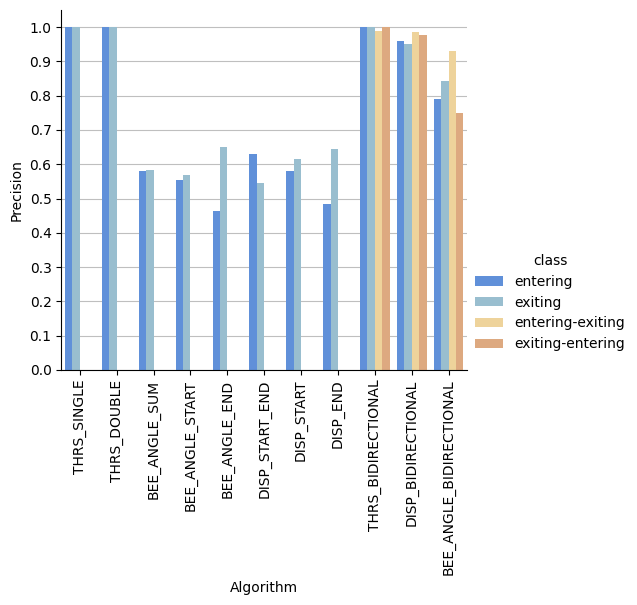

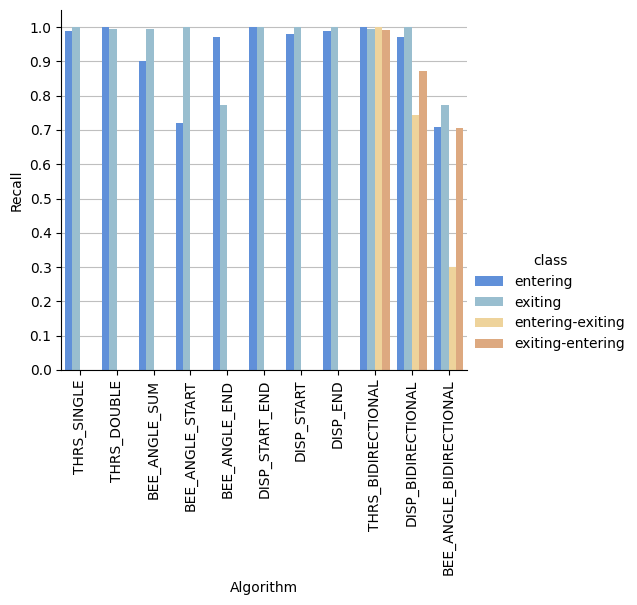

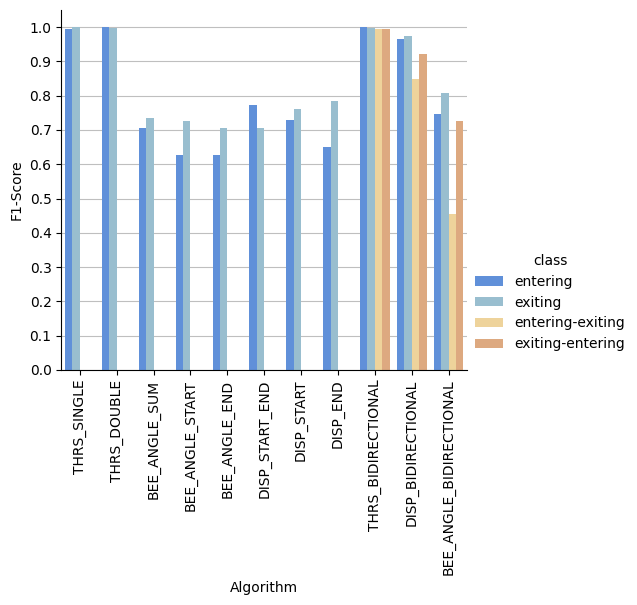

In [53]:
generate_sidegraphs(global_dict,"global")

In [54]:
global_matrix['Actual Values'] = cheatsheet2['event']

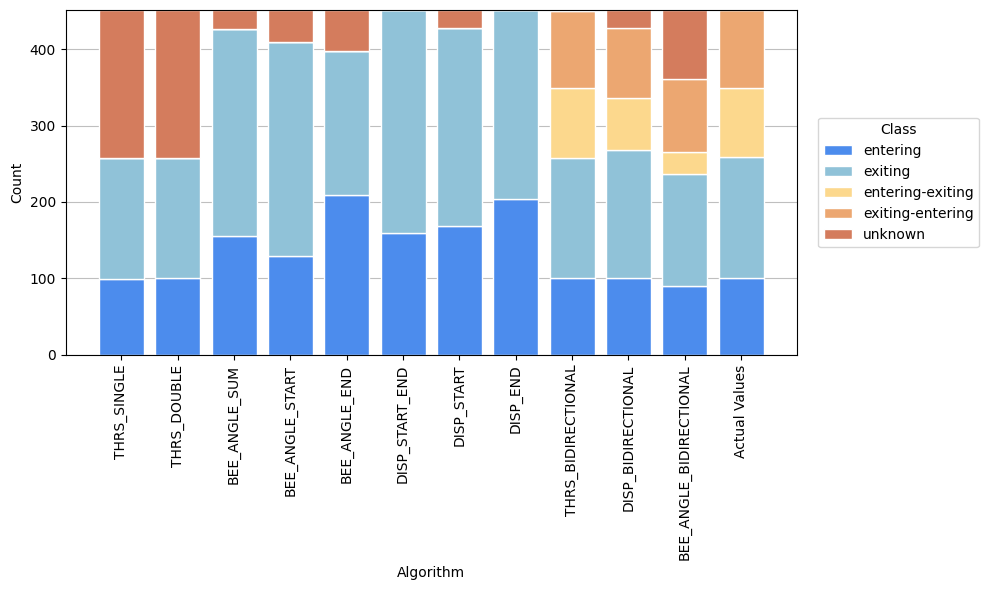

In [55]:
generate_dist(global_matrix,"global")

In [56]:
cheatsheettest = cheatsheet2.reset_index()

In [57]:
global_matrix[global_matrix['THRS_BIDIRECTIONAL'] != cheatsheettest['event']]['THRS_BIDIRECTIONAL']

17    entering-exiting
81             unknown
Name: THRS_BIDIRECTIONAL, dtype: object

In [58]:
cheatsheet2.iloc[81]

index           81
eventid         81
event      exiting
Name: 81, dtype: object

In [59]:
global_matrix['DISP_BIDIRECTIONAL'].iloc[81]

'exiting'

In [60]:
labels =['entering-exiting','exiting-entering']

In [61]:
cheatsheet['event'].value_counts()

event
exiting             159
exiting-entering    102
entering            100
entering-exiting     90
unknown               3
Name: count, dtype: int64

In [62]:
len(cheatsheet)

454

In [63]:
vdf['track_id'].nunique()

598

In [64]:
len(vdf.groupby(['video_name','track_id']))

604